# **Домашнее задание №1 (pro)**

В этом домашнем задании вам будет необходимо:
*  обучить модель регрессии для предсказания стоимости автомобилей;
* реализовать веб-сервис для применения построенной модели на новых данных

> Оценка за домашку = $min(\text{ваш балл}, 11)$

**Мягкий дедлайн: 27 ноября 23:59**

**Жесткий дедлайн: 20 декабря 23:59 (конец модуля)**



**Примечание**

В каждой части оцениваются как код, **так и ответы на вопросы.** Вопросы подсвечены синим цветом.

Если нет одного и/или другого, то часть баллов за соответствующее задание снимается.

In [295]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import pickle

random.seed(42)
np.random.seed(42)

### **Задание 0**
Для чего фиксируем сиды в домашках?

*random.seed() влияет на случайность, инициализируя генератор случайных чисел в фиксированном состоянии. Это делает последовательность чисел предсказуемой и повторяемой, но только если используется одно и то же начальное число. Без установки начального числа сгенерированные числа будут разными при каждом запуске.*

# **Часть 1 | EDA**


Первая часть состоит из классических шагов EDA:

- Базовый EDA и обработка признаков (1.7 балла)
- Визуализации признаков и их анализ (1.6 балл)

Всего можно набрать 3.3 основных балла и 0.25 бонусных.

В следующих частях, вы увидите бонусные задания. Бонусные задания выделены как **Дополнительное задание/Бонус**. Вы можете выполнять их, чтобы в случае ошибок в основных задачах всё равно набрать за работу максимум. Кроме того, дополнительные задания позволяют вам углубить знания.

Призываем активно использовать их!

## **Простейший EDA и обработка признаков (1.7 балла)**

In [296]:
df_train = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv')

print("Train data shape:", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape: (6999, 13)
Test data shape:  (1000, 13)


### **Задание 1.(0.4 балла)**
Выполните операции, направленные на базовое исследование данных:

- [ ] Посмотрите, есть ли в датасете пропуски и дубликаты. Запишите/выведите названия колонок, для которых есть пропущенные значения (0.1 балла)
- [ ] Посмотрите, есть ли в данных явные дубликаты (0.05 балла)
- [ ] Постройте дашборд в одну строку, используя [ydata-profilling](https://github.com/ydataai/ydata-profiling)(0.15 балла)
- [ ] Опишите базовые выводы (какие — выберите сами), используя дашборд (0.2 балла)

In [297]:
df_train.isnull().sum()[df_train.isnull().sum() > 0], df_test.isnull().sum()[df_test.isnull().sum() > 0]

(mileage      202
 engine       202
 max_power    196
 torque       203
 seats        202
 dtype: int64,
 mileage      19
 engine       19
 max_power    19
 torque       19
 seats        19
 dtype: int64)

In [298]:
df_train.duplicated().sum(), df_test.duplicated().sum()

(985, 62)

In [299]:
df_train.isnull().sum()[df_train.isnull().sum() > 0].index.tolist(),df_test.isnull().sum()[df_test.isnull().sum() > 0].index.tolist()

(['mileage', 'engine', 'max_power', 'torque', 'seats'],
 ['mileage', 'engine', 'max_power', 'torque', 'seats'])

In [300]:
#keep=False все дубликаты
df_train.duplicated(subset=['name','year','selling_price','km_driven','fuel','seller_type','transmission','owner','mileage','engine','max_power','torque','seats'],keep=False).sum()

1478

In [301]:
df_test.duplicated(keep=False).sum()

95

In [302]:
pip install pandas-profiling

In [303]:
from ydata_profiling import ProfileReport
ProfileReport(df_train, title='Cars Dataset Profile', explorative=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Выводы по дашборду:
* Дубли:Dataset has 493 (7.0%), пропуски 2.9%
* Влияния столбоц и из корреляция
 ** Высокая корреляция:
 km_driven-year
 selling_price - transmission and 1 other fields  
 transmission - selling_price
 year - km_driven and 1 other fields
 seller_type "перекос данных" (51.8%)
* Описание типов данных, текст, категориальные (transmission,owner)

### **Задание 2 (0.2 балла)**
Проанализируйте статистики датасета.

**Ваша задача:**
- [ ] Посчитайте основные статистики по числовым столбцам для трейна и теста
- [ ] Посчитайте основные статистики по категориальным столбцам для трейна и теста
- [ ] Сравните среднее и медиану внутри `train`, внутри `test` и между собой. О чём могут говорить результаты?

**Подсказка:**

Используте ``.describe()`` с нужным(и) аргументом(-ами).

In [304]:
df_train.describe(), df_test.describe()

(              year  selling_price     km_driven        seats
 count  6999.000000   6.999000e+03  6.999000e+03  6797.000000
 mean   2013.818403   6.395152e+05  6.958462e+04     5.419008
 std       4.053095   8.089419e+05  5.772400e+04     0.965767
 min    1983.000000   2.999900e+04  1.000000e+00     2.000000
 25%    2011.000000   2.549990e+05  3.500000e+04     5.000000
 50%    2015.000000   4.500000e+05  6.000000e+04     5.000000
 75%    2017.000000   6.750000e+05  9.700000e+04     5.000000
 max    2020.000000   1.000000e+07  2.360457e+06    14.000000,
               year  selling_price      km_driven       seats
 count  1000.000000   1.000000e+03    1000.000000  981.000000
 mean   2013.681000   6.179010e+05   71393.341000    5.410805
 std       4.012149   7.585539e+05   48486.218662    0.919985
 min    1995.000000   3.100000e+04    1303.000000    4.000000
 25%    2011.000000   2.500000e+05   37000.000000    5.000000
 50%    2014.000000   4.349990e+05   61500.000000    5.000000
 75%   

In [305]:
df_train.describe(include=['object']),df_test.describe(include=['object'])

(                          name    fuel seller_type transmission        owner  \
 count                     6999    6999        6999         6999         6999   
 unique                    1924       4           3            2            5   
 top     Maruti Swift Dzire VDI  Diesel  Individual       Manual  First Owner   
 freq                       116    3793        5826         6095         4587   
 
           mileage   engine max_power          torque  
 count        6797     6797      6803            6796  
 unique        386      120       316             419  
 top     18.9 kmpl  1248 CC    74 bhp  190Nm@ 2000rpm  
 freq          197      885       330             468  ,
                        name    fuel seller_type transmission        owner  \
 count                  1000    1000        1000         1000         1000   
 unique                  621       4           3            2            5   
 top     Maruti Alto 800 LXI  Diesel  Individual       Manual  First Owner   


In [306]:
train_mean = df_train.select_dtypes([int, float]).mean()
train_median = df_train.select_dtypes([int, float]).median()

test_mean = df_test.select_dtypes([int, float]).mean()
test_median = df_test.select_dtypes([int, float]).median()

pd.DataFrame({
    'train_mean': train_mean,
    'test_mean': test_mean,
    'train_median': train_median,
    'test_median': test_median
})

train_mean      test_mean  train_median  test_median
year             2013.818403    2013.681000        2015.0       2014.0
selling_price  639515.197171  617901.042000      450000.0     434999.0
km_driven       69584.615517   71393.341000       60000.0      61500.0
seats               5.419008       5.410805           5.0          5.0

Выводы:
* Тренировочном и тестовом наборах данных есть схожие распределения для большинства переменных, но есть и небольшие различия (например, в возрасте автомобилей и пробеге), которые могут быть полезными для анализа.
* В столбцах, таких как selling_price и km_driven, есть разница между средним и медианой, что указывает на асимметричные распределения или наличие выбросов.
* Различия между тренингом и тестом могут указывать на небольшие различия в выборке, что важно учитывать при построении модели, так как это может повлиять на её обобщающие способности


### **Задание 3 (0.2 балла)**

- [ ] Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием (целевую переменную следует исключить). Если есть, то сколько? (0.05 балла)
- [ ] Отобразите такие объекты (0.05 балла)
- [ ] Удалите повторяющиеся строки. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю (0.05 балла)
- [ ]  Обновите индексы строк таким образом, чтобы они шли от 0 без пропусков (0.05 балла)

In [307]:
df_train_without_target = df_train.drop(columns=['selling_price'])
duplicates = df_train_without_target[df_train_without_target.duplicated()]
duplicates.shape[0]

1159

In [308]:
duplicates

name  year  km_driven    fuel  \
254                   Hyundai Grand i10 Sportz  2017      35000  Petrol   
258                           Maruti Swift VXI  2012      50000  Petrol   
268                     Maruti Swift Dzire VXI  2014      70000  Petrol   
324   Jaguar XE 2016-2019 2.0L Diesel Prestige  2017       9000  Diesel   
325                              Lexus ES 300h  2019      20000  Petrol   
...                                        ...   ...        ...     ...   
6947                    Chevrolet Spark 1.0 LS  2010      60000  Petrol   
6984  Ford Freestyle Titanium Plus Diesel BSIV  2018      24000  Diesel   
6989                    Maruti Swift Dzire VDI  2015      50000  Diesel   
6997                           Tata Indigo CR4  2013      25000  Diesel   
6998                           Tata Indigo CR4  2013      25000  Diesel   

     seller_type transmission         owner     mileage   engine   max_power  \
254   Individual       Manual   First Owner   18.9 kmpl  1197 CC      82 bhp   
258   Individual       Manual  Second Owner   18.6 kmpl  1197 CC    85.8 bhp   
268   Individual       Manual  Second Owner   19.1 kmpl  1197 CC    85.8 bhp   
324       Dealer    Automatic   First Owner   13.6 kmpl  1999 CC     177 bhp   
325       Dealer    Automatic   First Owner  22.37 kmpl  2487 CC  214.56 bhp   
...          ...          ...           ...         ...      ...         ...   
6947  Individual       Manual  Second Owner   18.0 kmpl   995 CC      62 bhp   
6984  Individual       Manual   First Owner   24.4 kmpl  1498 CC   98.63 bhp   
6989  Individual       Manual   First Owner  26.59 kmpl  1248 CC      74 bhp   
6997  Individual       Manual   First Owner  23.57 kmpl  1396 CC      70 bhp   
6998  Individual       Manual   First Owner  23.57 kmpl  1396 CC      70 bhp   

                   torque  seats  
254        114Nm@ 4000rpm    5.0  
258        114Nm@ 4000rpm    5.0  
268        114Nm@ 4000rpm    5.0  
324   430Nm@ 1750-2500rpm    5.0  
325   202Nm@ 3600-5200rpm    5.0  
...                   ...    ...  
6947      90.3Nm@ 4200rpm    5.0  
6984  215Nm@ 1750-3000rpm    5.0  
6989       190Nm@ 2000rpm    5.0  
6997  140Nm@ 1800-3000rpm    5.0  
6998  140Nm@ 1800-3000rpm    5.0  

[1159 rows x 12 columns]

In [309]:
df_train = df_train.loc[~df_train_without_target.duplicated(keep='first')]

In [310]:
df_train = df_train.reset_index(drop=True)

In [311]:
assert df_train.shape == (5840, 13)

### **Задание 4 (0.3 балла)**

Вы могли заметить, что с признаками ``mileage, engine, max_power и torque`` всё не очень хорошо. Они распознаются как строки (можно убедиться в этом, вызвав `data.dtypes`). Однако эти переменные не являются категориальными — они — числа. Соответственно, нужно привести их к числовому виду.

**Задача :**
* [ ] Уберите единицы измерения для признаков ``mileage, engine, max_power``.
* [ ] Приведите тип данных к ``float``.
* [ ] Предобработайте признак `torque` — разделите его на два: собственно `torque` и `max_torque_rpm`. Учтите единицы измерения


**Важно**
- Все действия нужно производить над обоими датасетами — `train` и `test`.

In [312]:
df_train['mileage'] = df_train['mileage'].str.replace(r'[^0-9.]', '', regex=True)
df_train['engine'] = df_train['engine'].str.replace(r'[^0-9.]', '', regex=True)
df_train['max_power'] = df_train['max_power'].str.replace(r'[^0-9.]', '', regex=True)
df_test['mileage'] = df_test['mileage'].str.replace(r'[^0-9.]', '', regex=True)
df_test['engine'] = df_test['engine'].str.replace(r'[^0-9.]', '', regex=True)
df_test['max_power'] = df_test['max_power'].str.replace(r'[^0-9.]', '', regex=True)

In [313]:
df_train['max_power'] = df_train['max_power'].replace('', np.nan)
df_test['max_power'] = df_test['max_power'].replace('', np.nan)

In [314]:
df_train['mileage'] = df_train['mileage'].astype(float)
df_train['engine'] = df_train['engine'].astype(float)
df_train['max_power'] = df_train['max_power'].astype(float)
df_test['mileage'] = df_test['mileage'].astype(float)
df_test['engine'] = df_test['engine'].astype(float)
df_test['max_power'] = df_test['max_power'].astype(float)

In [315]:
import re

def parse_torque(torque_str):
    if pd.isna(torque_str):
        return np.nan, np.nan
    torque_str = str(torque_str)
    torque_str = torque_str.lower().strip()
    if torque_str == 'null':
        return np.nan, np.nan
    value = None
    rpm_range = None
    units = None
    min_rpm_range = None
    #'210 / 1900'
    pattern = r'([\d\.]+)\s*(|nm)\s*(/)\s*([\d\,]+)\s*(|rpm)'
    match = re.match(pattern, torque_str)
    if match:
        value = float(match.group(1))
        if match.group(3) != '/':
          rpm_range = float(match.group(3))
        else:
          rpm_range = float(match.group(4))
        return value, rpm_range, min_rpm_range,1
    #'51nm@ 4000+/-500rpm'
    pattern = r'(\d+)\s*nm@?\s*(\d+)\s*\+/-\s*(\d+)\s*rpm'
    match = re.match(pattern, torque_str)
    if match:
        value = float(match.group(1))
        rpm_range = float(match.group(2))+float(match.group(3))
        min_rpm_range = float(match.group(2))-float(match.group(3))
        return value, rpm_range, min_rpm_range,2
    #48@ 3,000+/-500(nm@ rpm)
    pattern = r'(\d+)\s*@\s*([\d,]+)\s*\+/-\s*(\d+)\s*\(nm@ rpm\)'
    match = re.match(pattern, torque_str)
    if match:
        value = float(match.group(1).replace(',',''))
        rpm_range = float(match.group(2).replace(',',''))+float(match.group(3).replace(',',''))
        min_rpm_range = float(match.group(2).replace(',',''))-float(match.group(3).replace(',',''))
        return value, rpm_range, min_rpm_range,3
    pattern = r'([\d\.]+)\s*(|kgm|nm)\s*(@|at)\s*([\d\,]+)(-|~)([\d\,]+)\s*(|rpm)'
    match = re.match(pattern, torque_str)
    if match:
        if match.group(2) == 'kgm':
            value = float(match.group(1)) * 9.81  # конвертация в Nm
        value = float(match.group(1))
        rpm_range = float(match.group(6).replace(',',''))
        min_rpm_range = float(match.group(4).replace(',',''))
        return value, rpm_range, min_rpm_range,5
    #'20.4@ 1400-3400(kgm@ rpm)'
    pattern = r'([\d\.]+)\s*(@|at)\s*([\d\,]+)(-|~)([\d\,]+)(\()(kgm)\s*(@|at)\s*(rpm)(\))'
    match = re.match(pattern, torque_str)
    if match:
        if match.group(7) == 'kgm':
            value = float(match.group(1)) * 9.81  # конвертация в Nm
        value = float(match.group(1))
        rpm_range = float(match.group(5).replace(',',''))
        min_rpm_range = float(match.group(3).replace(',',''))
        return value, rpm_range, min_rpm_range,6
    pattern = r'([\d\.]+)\s*(kgm|nm)\s*(@|at)\s*([\d\,]+)\s*(|rpm)'
    match = re.match(pattern, torque_str)
    if match:
        value = float(match.group(1))
        rpm_range = float(match.group(4).replace(',',''))
        return value, rpm_range, min_rpm_range,4
    pattern = r'([\d\.]+)\s*(@|at)\s*([\d\,]+)(\()(kgm|nm)\s*(@|at)\s*(rpm)(\))'
    match = re.match(pattern, torque_str)
    if match:
        if match.group(5) == 'kgm':
            value = float(match.group(1)) * 9.81  # конвертация в Nm
        value = float(match.group(1))
        rpm_range = float(match.group(3).replace(',',''))
        return value, rpm_range, min_rpm_range,7
    pattern = r'(\d+)\s*nm\(([\d.]+)kgm\)@\s*(\d+)rpm'
    match = re.match(pattern, torque_str)
    if match:
        value = float(match.group(1))
        rpm_range = float(match.group(3).replace(',',''))
        return value, rpm_range, min_rpm_range,71
    pattern = r'(\d+)\s*nm'
    match = re.match(pattern, torque_str)
    if match:
        value = float(match.group(1))
        return value, rpm_range, min_rpm_range,8
    # Обработка возможных форматов
 #   if torque_str != '' and  (rpm_range == None and value == None):
 #     print(f"{torque_str}^^{value}^^{rpm_range}")
    #print(f"{torque_str}^^{value}^^{rpm_range}")
  #  return value, rpm_range, min_rpm_range

In [316]:
df_train[['torque_value','max_torque_rpm','min_rpm_range','torque_alg']] = df_train['torque'].apply(lambda x: pd.Series(parse_torque(x)))

In [317]:
df_test[['torque_value','max_torque_rpm','min_rpm_range','torque_alg']] = df_test['torque'].apply(lambda x: pd.Series(parse_torque(x)))
#My column for check
df_test = df_test.drop('torque_alg', axis=1)
df_train = df_train.drop('torque_alg', axis=1)

### **Задание 5 (0.3 балла)**

На первом шаге мы обнаружили пропуски. Давайте избавимся от них.

**Задание:**
- [ ] Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось.
- [ ] Почему стоит применять именно медиану. Могли ли мы применить среднее? Обоснуйте свое рассуждение.
- [ ] Как правильно считать медиану для заполнения? Выберите верное утверждение:
 - По тестовым свою, по тренировочным — свою
 - По тренировочным данным для `train` и `test`






In [318]:
#print(df_test[df_test.isnull().any(axis=1)].to_string())

In [319]:
df_train_with_nan = df_train.copy()
df_test_with_nan = df_test.copy()

In [320]:
for column in df_train.isnull().sum()[df_train.isnull().sum() > 0].index.tolist():
  if df_train[column].dtype == 'float':
    median = df_train[column].median()
    df_train[column] = df_train[column].fillna(median)
    df_test[column] = df_test[column].fillna(median)

* Медиана не чувствительна к выбросам
* Медиана используется для нормальных распределений,
* Среднее применяется для параметры, которые, как правило, распределяются нормально, без значительных выбросов


* Медиану по тренировочным данным для заполнения пропусков как в тренировочном наборе данных (train), так и в тестовом наборе данных (test)
* Сохранить целостность данных и избежать утечек данных

In [321]:
df_train.isnull().sum()[df_train.isnull().sum() > 0].index.tolist()

['torque']

In [322]:
#print(df_test[df_test.isnull().any(axis=1)].to_string())

In [323]:
df_train.isnull().sum()[df_train.isnull().sum() > 0], df_test.isnull().sum()[df_test.isnull().sum() > 0]

(torque    187
 dtype: int64,
 torque    19
 dtype: int64)

### **Задание 6 (0.2 балла)**

Теперь, когда не осталось пропусков, давайте преобразуем столбцы к более подходящим типам. А именно столбцы ``engnine`` и ``seats`` к приведем к `int`.

- [ ] Осуществите приведение столбцов к необходимому типу.
- [ ] Ответье на вопрос — почему (хоть мы этого и не делаем) ``seats``, возможно рассмотреть как категориальную переменную?

In [324]:
df_train['engine'] = df_train['engine'].astype(int)
df_test['engine'] = df_test['engine'].astype(int)

In [325]:
df_train['seats'] = df_train['seats'].astype(int)
df_test['seats'] = df_test['seats'].astype(int)

Если использовать как числовая переменная то чем больше мест тем лучше, что не имеет смысла в контексте автомобильных характеристик.

Категориальная переменную, то модель будет рассматривать разные типы автомобилей как отдельные классы, что может быть более подходящим для решения задачи.

Категориальная "+":

Количество уникальных значений ограничено.

Эти значения могут представлять разные категории автомобилей

Позволяет избежать неверных предположений о порядке между значениями в контексте автомобильных характеристик.

### **Задание 7 (0.1 балла)**

Снова вызовите метод describe и проанализируйте статистики.

**Ответье на вопрос:**
- [ ] Есть ли основания предполагать, что заполнение пропусков свдинуло наши распределения? Могло ли это вообще возникнуть?

In [326]:
'''
 (              year  selling_price     km_driven        seats
 count  6999.000000   6.999000e+03  6.999000e+03  6797.000000
 mean   2013.818403   6.395152e+05  6.958462e+04     5.419008
 std       4.053095   8.089419e+05  5.772400e+04     0.965767
 min    1983.000000   2.999900e+04  1.000000e+00     2.000000
 25%    2011.000000   2.549990e+05  3.500000e+04     5.000000
 50%    2015.000000   4.500000e+05  6.000000e+04     5.000000
 75%    2017.000000   6.750000e+05  9.700000e+04     5.000000
 max    2020.000000   1.000000e+07  2.360457e+06    14.000000,
               year  selling_price      km_driven       seats
 count  1000.000000   1.000000e+03    1000.000000  981.000000
 mean   2013.681000   6.179010e+05   71393.341000    5.410805
 std       4.012149   7.585539e+05   48486.218662    0.919985
 min    1995.000000   3.100000e+04    1303.000000    4.000000
 25%    2011.000000   2.500000e+05   37000.000000    5.000000
 50%    2014.000000   4.349990e+05   61500.000000    5.000000
 75%    2017.000000   6.700000e+05  100000.000000    5.000000
 max    2020.000000   6.000000e+06  375000.000000    9.000000)
'''

'\n (              year  selling_price     km_driven        seats\n count  6999.000000   6.999000e+03  6.999000e+03  6797.000000\n mean   2013.818403   6.395152e+05  6.958462e+04     5.419008\n std       4.053095   8.089419e+05  5.772400e+04     0.965767\n min    1983.000000   2.999900e+04  1.000000e+00     2.000000\n 25%    2011.000000   2.549990e+05  3.500000e+04     5.000000\n 50%    2015.000000   4.500000e+05  6.000000e+04     5.000000\n 75%    2017.000000   6.750000e+05  9.700000e+04     5.000000\n max    2020.000000   1.000000e+07  2.360457e+06    14.000000,\n               year  selling_price      km_driven       seats\n count  1000.000000   1.000000e+03    1000.000000  981.000000\n mean   2013.681000   6.179010e+05   71393.341000    5.410805\n std       4.012149   7.585539e+05   48486.218662    0.919985\n min    1995.000000   3.100000e+04    1303.000000    4.000000\n 25%    2011.000000   2.500000e+05   37000.000000    5.000000\n 50%    2014.000000   4.349990e+05   61500.000000 

In [327]:
df_train.describe(), df_test.describe()

(              year  selling_price     km_driven      mileage       engine  \
 count  5840.000000   5.840000e+03  5.840000e+03  5840.000000  5840.000000   
 mean   2013.428425   5.229601e+05  7.395224e+04    19.430841  1429.448973   
 std       4.095622   5.354320e+05  6.007114e+04     3.985973   485.662834   
 min    1983.000000   2.999900e+04  1.000000e+00     0.000000   624.000000   
 25%    2011.000000   2.500000e+05  3.900000e+04    16.950000  1197.000000   
 50%    2014.000000   4.050000e+05  7.000000e+04    19.370000  1248.000000   
 75%    2017.000000   6.400000e+05  1.000000e+05    22.300000  1498.000000   
 max    2020.000000   1.000000e+07  2.360457e+06    42.000000  3604.000000   
 
          max_power        seats  torque_value  max_torque_rpm  min_rpm_range  
 count  5840.000000  5840.000000   5840.000000     5840.000000    5840.000000  
 mean     87.906371     5.426712    161.309570     3046.645205    1691.809075  
 std      31.640418     0.982344     91.174286      912.

В столбце km_driven среднее значение увеличилось (с 69 584 до 73 952)
selling_price: 639 515 (до) против 522 960 (после) — средняя цена снизилась.
и т.д.

Заполнение пропусков могло повлиять на распределение данных, особенно в столбцах (например, selling_price). Заполнение медианными значениями, привело к уменьшению дисперсии и сглаживанию распределений.

Помоогло уменьшить разброс.

## **Визуализации и корреляция (1.6 балла + 0.25)**

Визуализация данных — важный шаг в работе. Визуализировать данные необходимо, например, чтобы:

- Оценить распределения признаков самих по себе (это может натоклнуть вас на мысли о модели, которую можно использовать)
- Сравнить распределения на `train` и `test` — чтобы проверить, насколько информация, на которой вы будете обучаться согласуется с той, на которой модель должна работать
- Оценить есть ли явная связь признаков с целевой переменной

**Важно:**

Если распределения на `train` и `test` не совпадают, это не значит, что нужно перемешивать данные! Более корректно актуализировать задачу и уточнить, а не устарели ли данные `train`. Также полезным может быть собрать новую тестовую выборку, смешав те, что имеются сейчас.

**Если вы будете подгонять распределения, то можете встретиться с переобучением!**

### **Задание 8 (0.5 балла)**

Шаг 1.
- [ ] Воспользуйтесь `pairplot` из библиотеки `seabron`, чтобы визуализировать попарные распределения числовых признаков для `train`
- [ ] По полученному графику ответьте на вопросы:
 - Можно ли предположить на основе распределений связь признаков с целевой переменной?
 - Можно ли предположить на основе распределений выдвинуть гипотезу о корреляциях признаков?

Шаг 2.

- [ ] Постройте pairplot по тестовым данным
- [ ] Ответьте на вопрос "Похожими ли оказались совокупности при разделении на трейн и тест?"

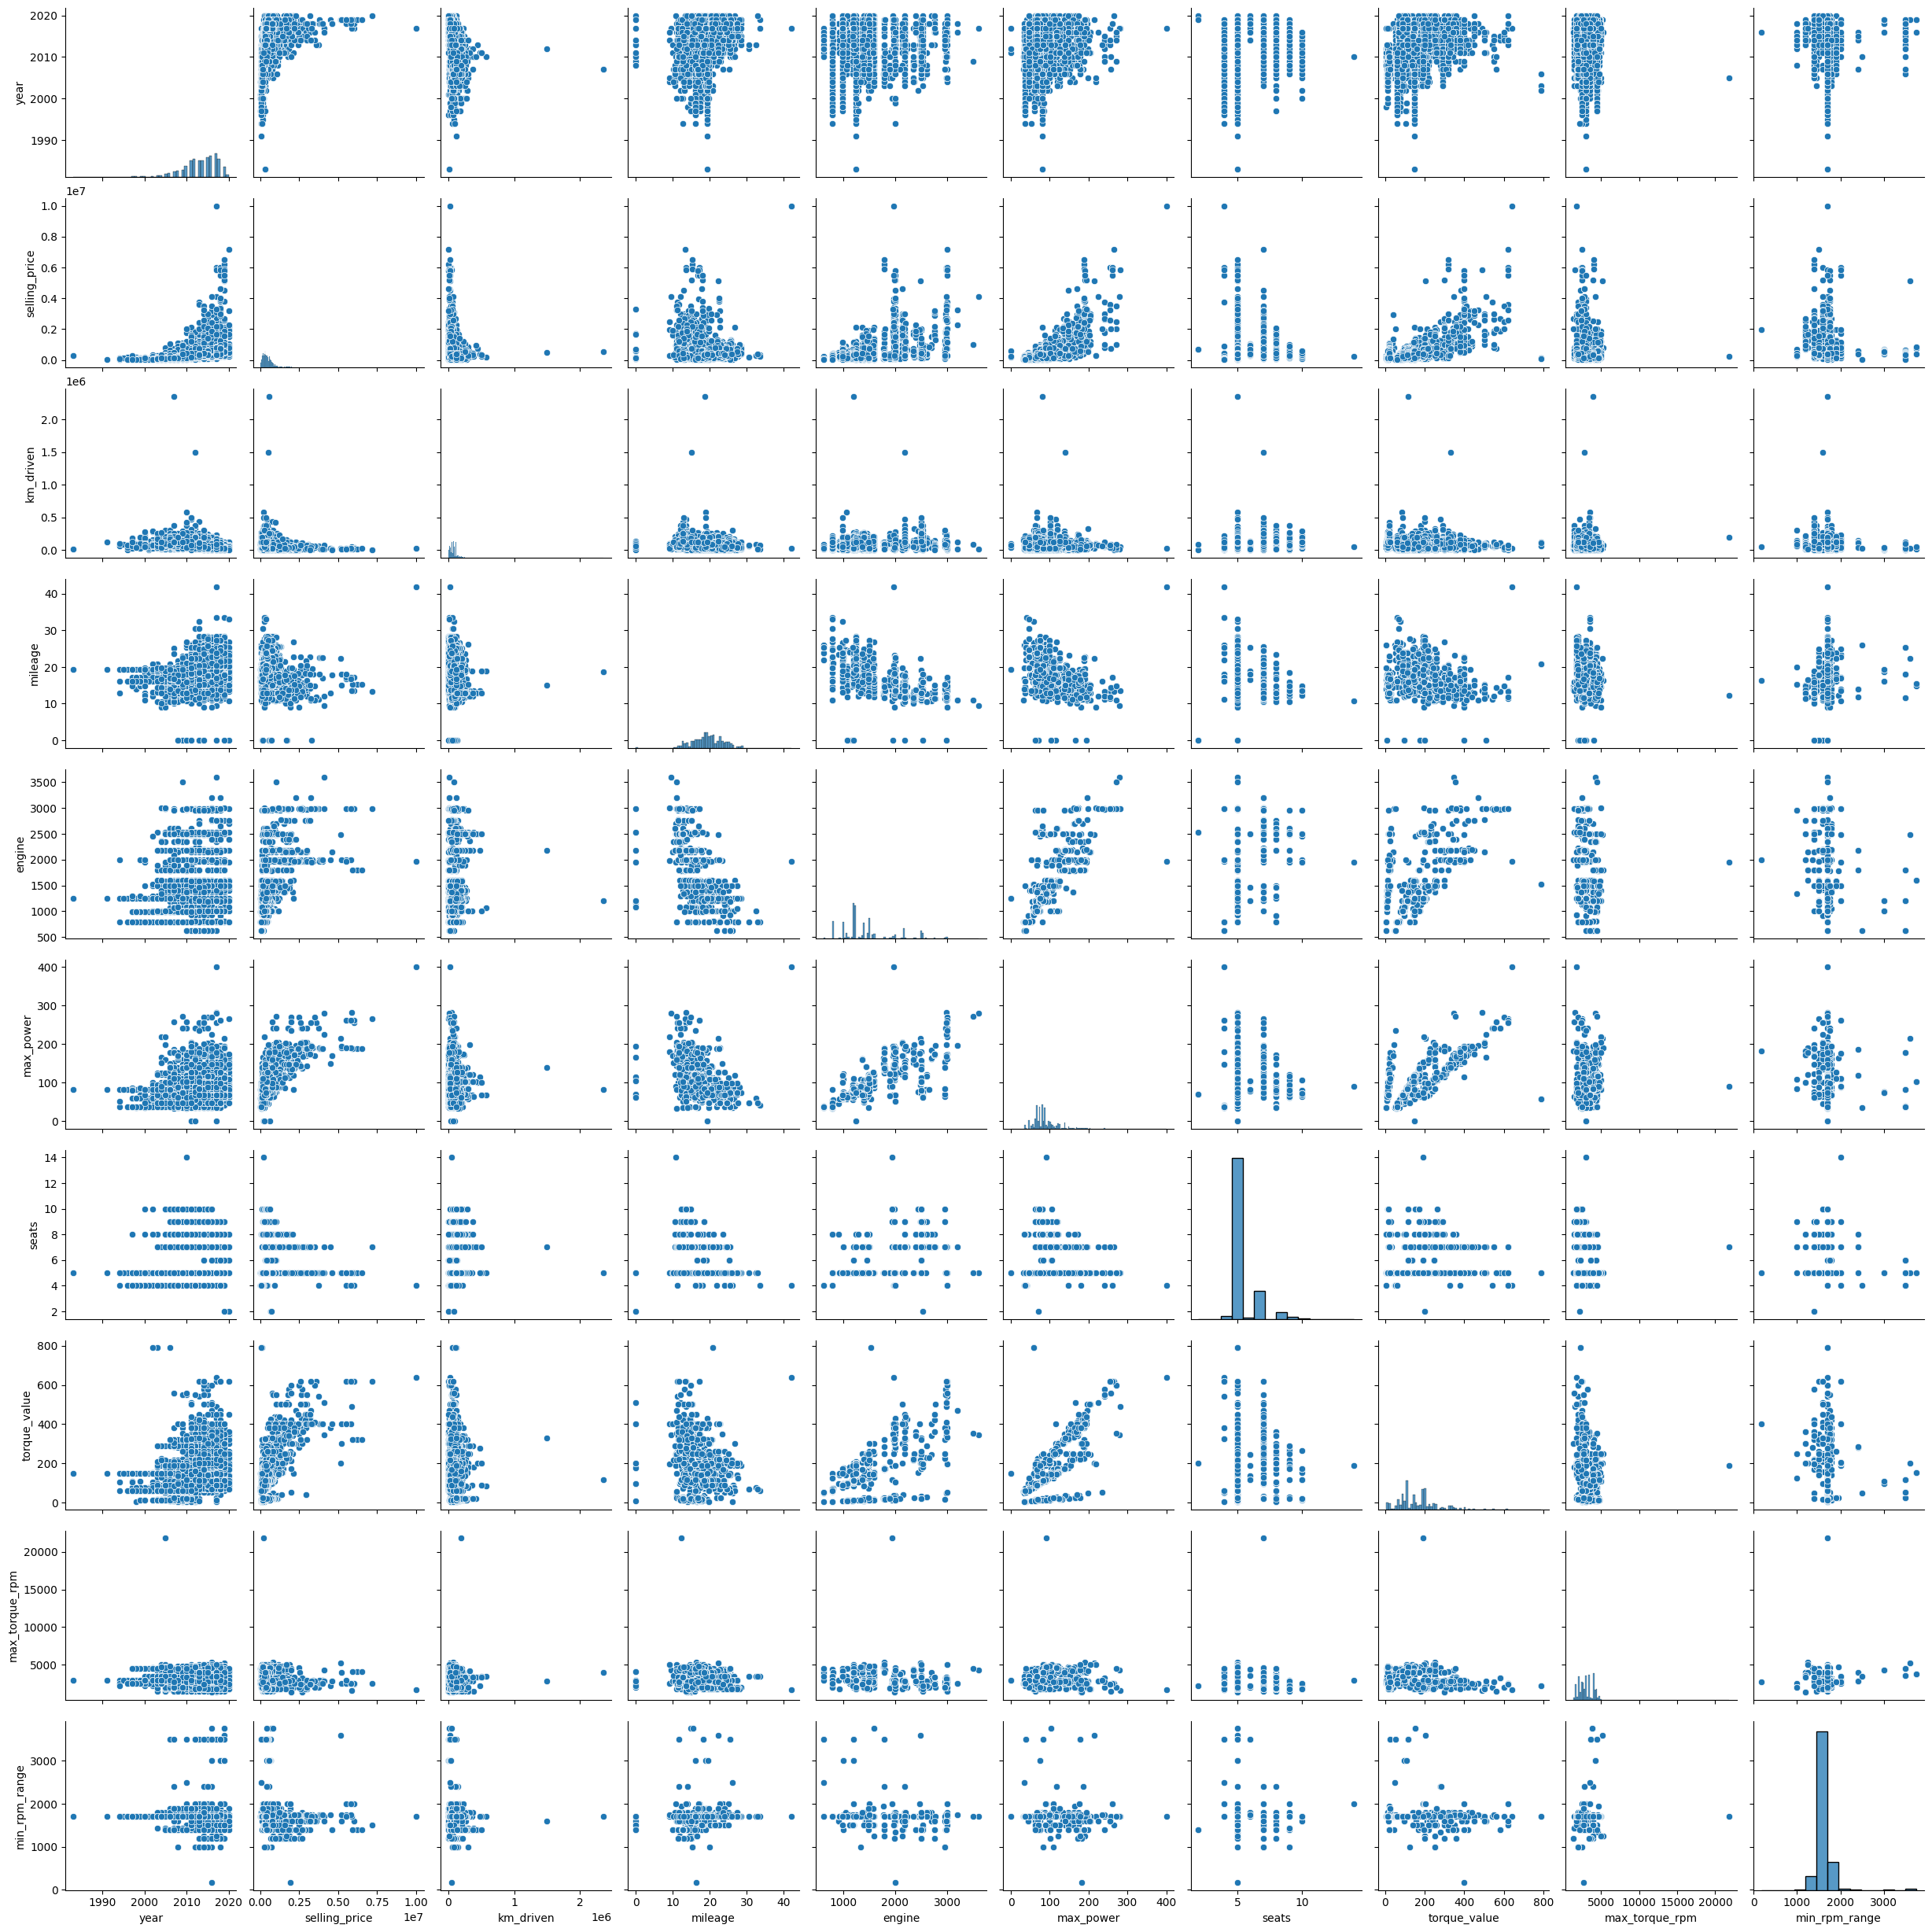

In [328]:
numeric_columns = df_train.select_dtypes(include='number')
sns.pairplot(numeric_columns, diag_kind = "hist")
  #plt.show()

✈ Можно ли предположить на основе распределений связь признаков с целевой переменной?

Для selling_price прослеживается линейная зависимость с max_power затем torque_value и после engine


✈ Можно ли предположить на основе распределений выдвинуть гипотезу о корреляциях признаков?

Парные графики играют важную роль в визуализации данных:
Тенденции: линейных или нелинейных связей, которые предполагают предсказуемость.
К примеру очень ярко выражена torque_value&max_power, есть обраные линейные зависимости к примеру mileage&engine

Конечно, по диагонале распределение нормальное распереление показателей

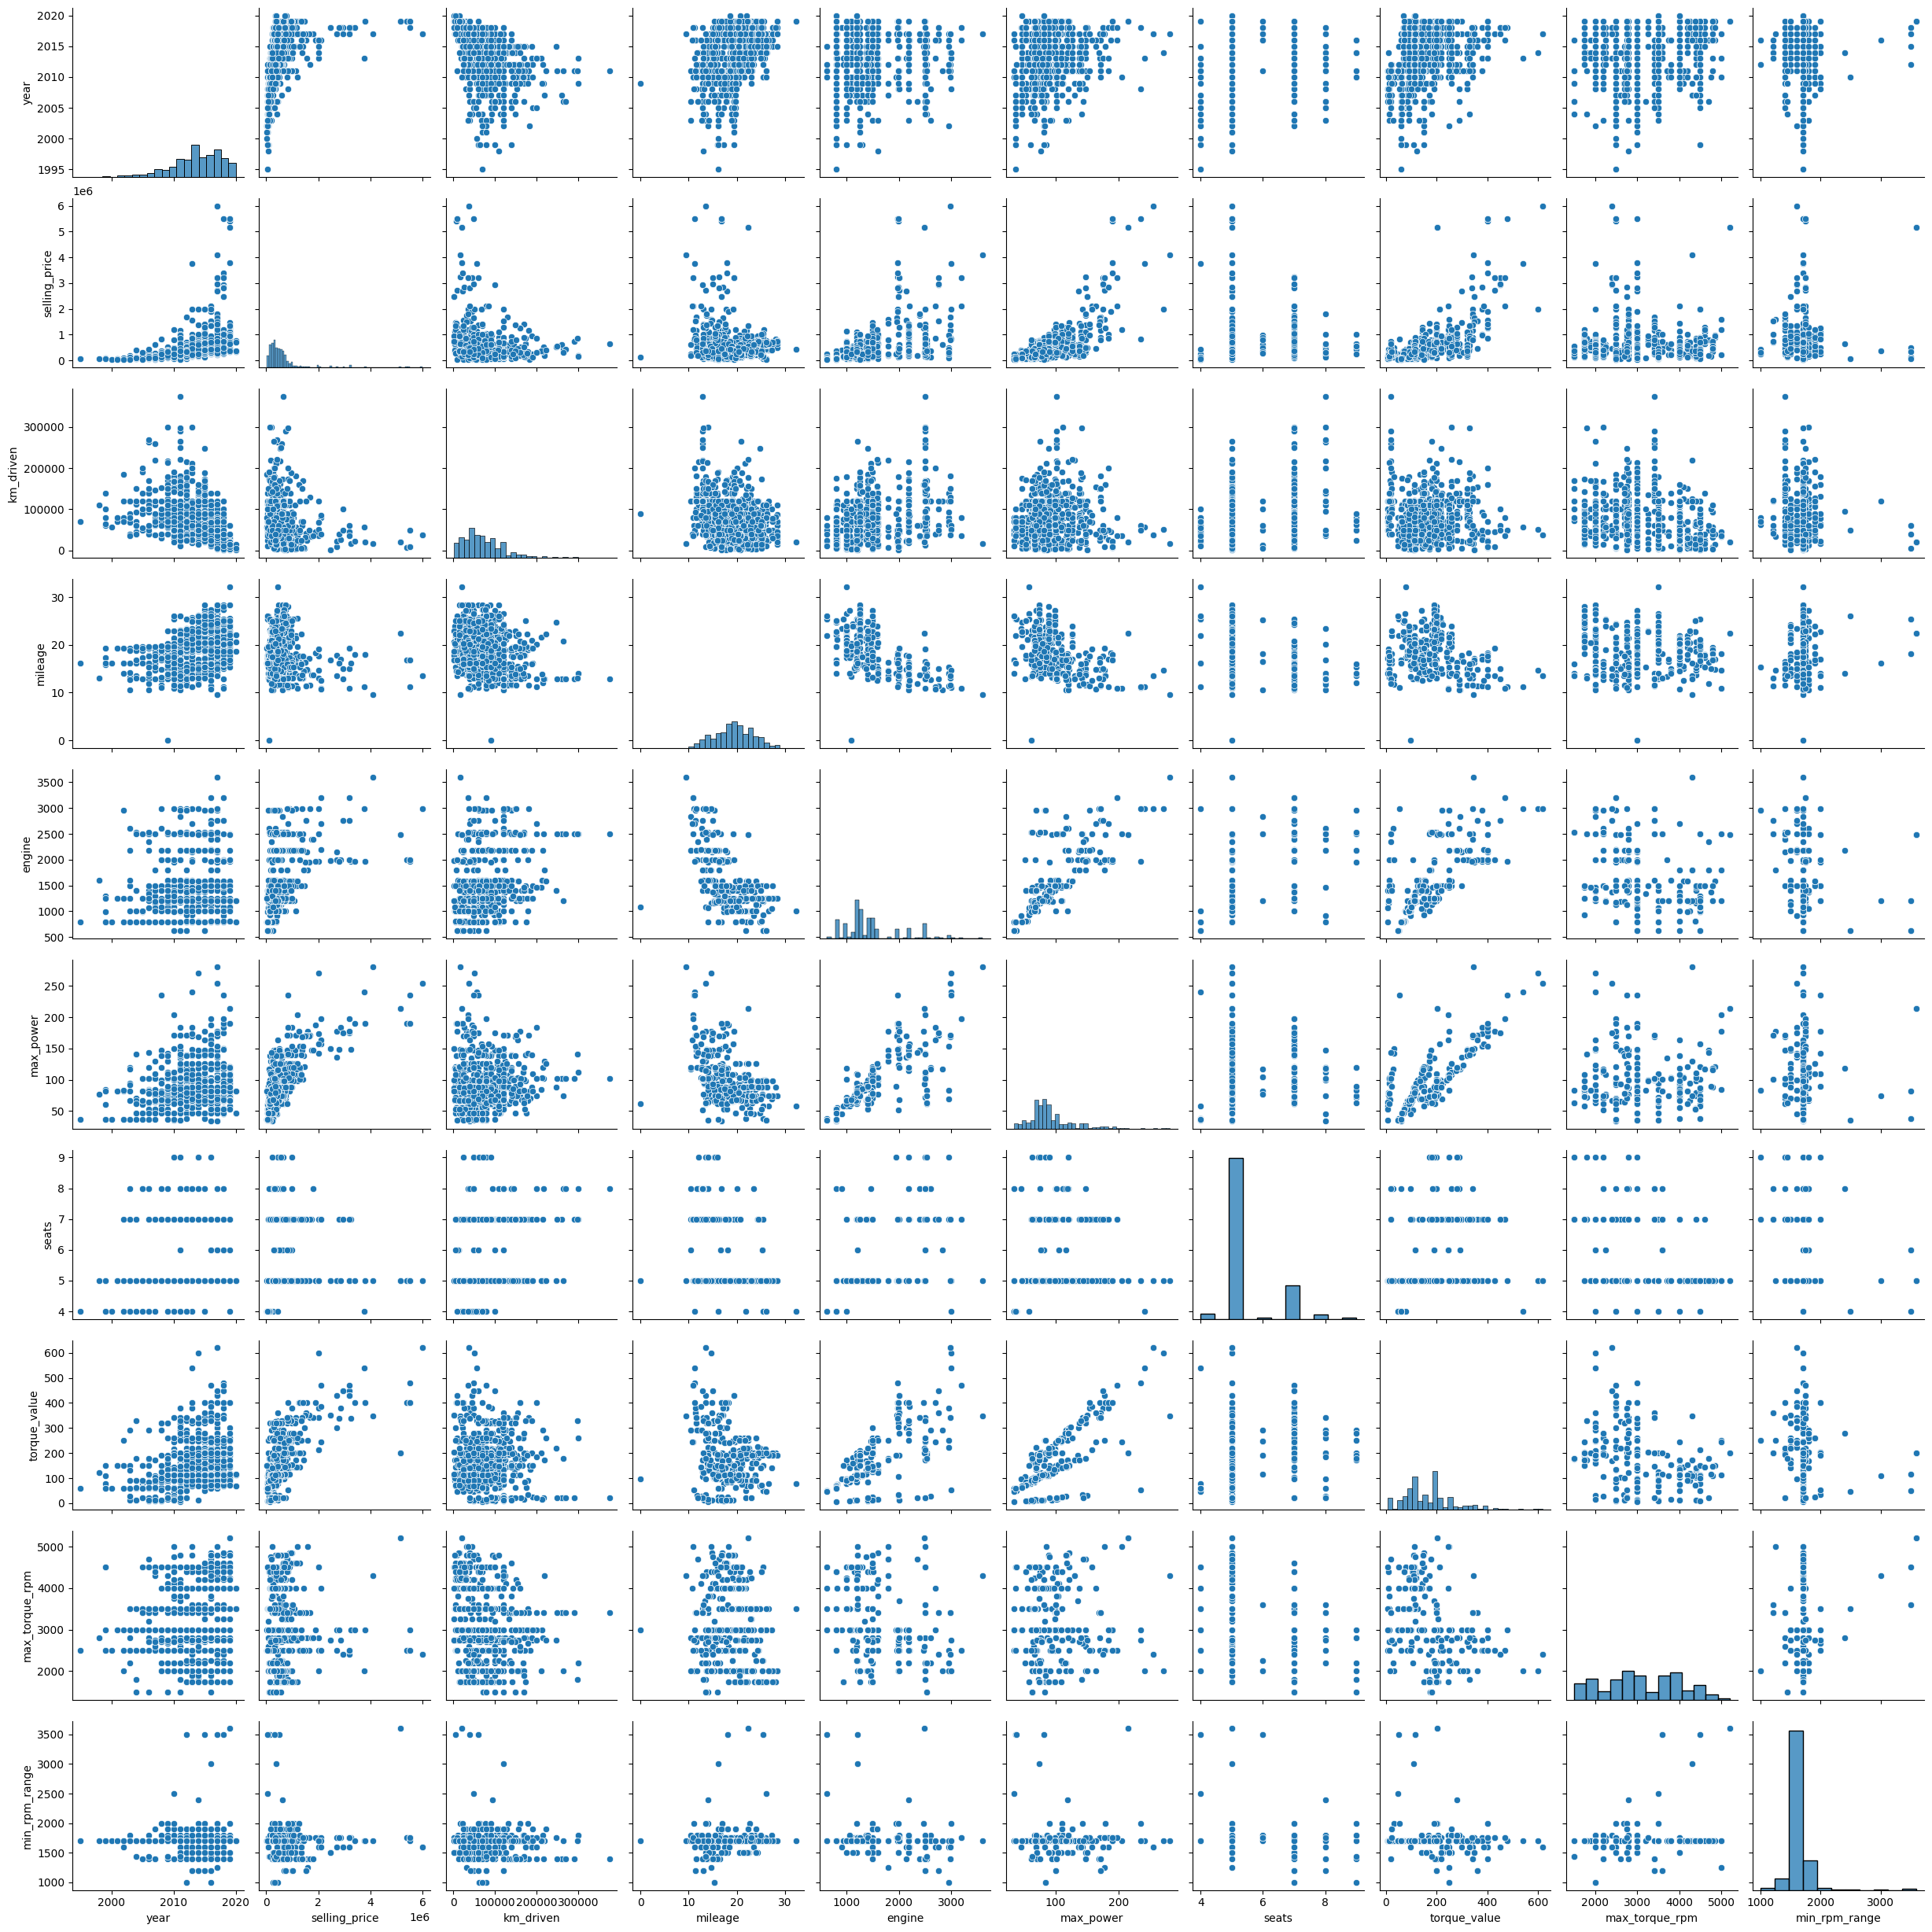

In [329]:
numeric_columns = df_test.select_dtypes(include='number')
sns.pairplot(numeric_columns)
#plt.show()

✈ Ответьте на вопрос "Похожими ли оказались совокупности при разделении на трейн и тест?"

Да, достаночно схожие, полный ответ в выводах

### **Задание 9 (0.5 балла)**

И так, вы выдвинули гипотезы о наличии связи. Теперь давайте оценим эту связь в числах.

**Задание:**
- [ ] Получите значения коэффициента корреляции Пирсона для тренировочного набора данных при помощи `pd.corr()`
- [ ] По полученным корреляциям постройте тепловую карту (`heatmap` из бибилотеки seaborn)

In [330]:
correlation_matrix = df_train.corr(numeric_only=True)
# Выводим матрицу корреляций
print(correlation_matrix.to_string())

                    year  selling_price  km_driven   mileage    engine  max_power     seats  torque_value  max_torque_rpm  min_rpm_range
year            1.000000       0.427279  -0.368966  0.341334  0.002819   0.156858  0.041178      0.250071        0.048432       0.017720
selling_price   0.427279       1.000000  -0.164828 -0.104769  0.447672   0.692814  0.149953      0.613397       -0.088720      -0.085940
km_driven      -0.368966      -0.164828   1.000000 -0.182086  0.229766   0.024588  0.192328      0.039362       -0.204651      -0.099424
mileage         0.341334      -0.104769  -0.182086  1.000000 -0.572893  -0.373390 -0.451059     -0.132415       -0.179445       0.157045
engine          0.002819       0.447672   0.229766 -0.572893  1.000000   0.681117  0.652172      0.612568       -0.246207      -0.286745
max_power       0.156858       0.692814   0.024588 -0.373390  0.681117   1.000000  0.244112      0.744652       -0.021474      -0.054974
seats           0.041178       0.149953  

<Axes: >

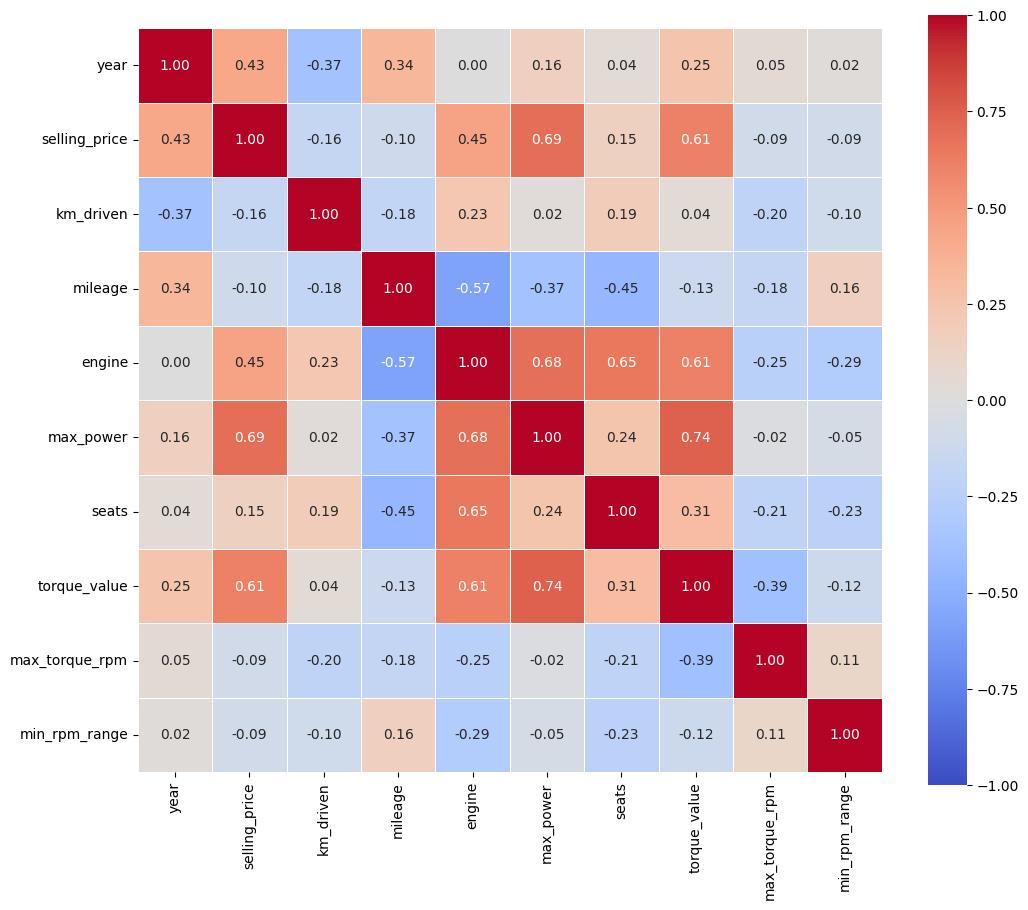

In [331]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_train.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f', cbar=True, square=True,
            linewidths=0.5, vmin=-1, vmax=1, annot_kws={"size": 10})

- [ ] Ответьте на вопросы:
 - Какие 2 признака наименее скоррелированы между собой?
 - Между какими наблюдается довольно сильная положительная линейная зависимость?
 - Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи?

✈ Какие 2 признака наименее скоррелированы между собой?

year&min_rpm_range

✈ Между какими наблюдается довольно сильная положительная линейная зависимость?

torque_value& max_power

✈ Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи?

year<< -> mileage>> - явной зависимости нет, если бы были доп. параметры к примеру "в такси" и т.д. то может быть :)

### **Задание 10 (0.6 балла)**

По умолчанию `pd.corr` возвращает корреляцию Пирсона, говорящую о линейной взаимосвязи. Но зависимости существуют не только линейные! В этой задаче, попробуйте измерить другие способы вычисления корреляций.

- [ ] Реализуйте корреляцию Спирмена/Кендала (на выбор) без использования библиотек (можно пользоваться только `numpy`). Сравните результаты вычисления с библиотечной реализацией
- [ ]

Постройте матрицу корреляции [phik](https://pypi.org/project/phik/)
- [ ] Проинтерпретируйте результаты


In [332]:
import numpy as np

def corr_spearman(a,b):
    x = np.array(a)
    y = np.array(b)
    rank_a = np.argsort(np.argsort(a)) + 1
    rank_b = np.argsort(np.argsort(b)) + 1
    d = rank_a - rank_b
    d_squared = np.sum(d**2)

    n = len(a)

    res = 1 - (6 * d_squared) / (n * (n**2 - 1))
    return res

In [333]:
corr_spearman(df_train['year'], df_train['selling_price'])

0.7050604986492461

In [334]:
spearman_corr_matrix = df_train.corr(numeric_only=True)

for col1 in df_train.select_dtypes(include=np.number).columns:
    for col2 in df_train.select_dtypes(include=np.number).columns:
        spearman_corr_matrix.loc[col1, col2] = corr_spearman(df_train[col1], df_train[col2])

spearman_corr_matrix

year  selling_price  km_driven   mileage    engine  \
year            1.000000       0.705060  -0.566218  0.342960 -0.034677   
selling_price   0.705060       1.000000  -0.295699  0.026164  0.461866   
km_driven      -0.566218      -0.295699   1.000000 -0.197687  0.303411   
mileage         0.342960       0.026164  -0.197687  1.000000 -0.428987   
engine         -0.034677       0.461866   0.303411 -0.428987  1.000000   
max_power       0.166875       0.612352   0.040464 -0.308684  0.711526   
seats           0.050485       0.220670   0.105454 -0.307221  0.361660   
torque_value    0.251839       0.617432   0.110638 -0.036333  0.683596   
max_torque_rpm  0.071432      -0.128938  -0.318030 -0.174770 -0.370427   
min_rpm_range   0.015247      -0.079700  -0.056142  0.196344 -0.126095   

                max_power     seats  torque_value  max_torque_rpm  \
year             0.166875  0.050485      0.251839        0.071432   
selling_price    0.612352  0.220670      0.617432       -0.128938   
km_driven        0.040464  0.105454      0.110638       -0.318030   
mileage         -0.308684 -0.307221     -0.036333       -0.174770   
engine           0.711526  0.361660      0.683596       -0.370427   
max_power        1.000000  0.200687      0.667502       -0.025185   
seats            0.200687  1.000000      0.249880       -0.130321   
torque_value     0.667502  0.249880      1.000000       -0.480096   
max_torque_rpm  -0.025185 -0.130321     -0.480096        1.000000   
min_rpm_range    0.017300  0.105328     -0.044682        0.036791   

                min_rpm_range  
year                 0.015247  
selling_price       -0.079700  
km_driven           -0.056142  
mileage              0.196344  
engine              -0.126095  
max_power            0.017300  
seats                0.105328  
torque_value        -0.044682  
max_torque_rpm       0.036791  
min_rpm_range        1.000000

In [335]:
df_train.corr(method='spearman',numeric_only=True)

year  selling_price  km_driven   mileage    engine  \
year            1.000000       0.707123  -0.569659  0.346132 -0.038056   
selling_price   0.707123       1.000000  -0.295665  0.026186  0.463577   
km_driven      -0.569659      -0.295665   1.000000 -0.198466  0.304504   
mileage         0.346132       0.026186  -0.198466  1.000000 -0.429871   
engine         -0.038056       0.463577   0.304504 -0.429871  1.000000   
max_power       0.165798       0.612258   0.040919 -0.308824  0.713113   
seats           0.048291       0.317605   0.195317 -0.435458  0.527716   
torque_value    0.250972       0.617821   0.110920 -0.036039  0.685731   
max_torque_rpm  0.076177      -0.128278  -0.321286 -0.175808 -0.373703   
min_rpm_range   0.006565      -0.091745  -0.055211  0.232311 -0.149053   

                max_power     seats  torque_value  max_torque_rpm  \
year             0.165798  0.048291      0.250972        0.076177   
selling_price    0.612258  0.317605      0.617821       -0.128278   
km_driven        0.040919  0.195317      0.110920       -0.321286   
mileage         -0.308824 -0.435458     -0.036039       -0.175808   
engine           0.713113  0.527716      0.685731       -0.373703   
max_power        1.000000  0.304857      0.668541       -0.026137   
seats            0.304857  1.000000      0.369463       -0.203730   
torque_value     0.668541  0.369463      1.000000       -0.482544   
max_torque_rpm  -0.026137 -0.203730     -0.482544        1.000000   
min_rpm_range    0.027686 -0.270694     -0.043801        0.028794   

                min_rpm_range  
year                 0.006565  
selling_price       -0.091745  
km_driven           -0.055211  
mileage              0.232311  
engine              -0.149053  
max_power            0.027686  
seats               -0.270694  
torque_value        -0.043801  
max_torque_rpm       0.028794  
min_rpm_range        1.000000

interval columns not set, guessing: ['year', 'selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'seats', 'torque_value', 'max_torque_rpm', 'min_rpm_range']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable name is large: 1924. Are you sure this is not an interval variable? Analysis for pairs of variables including name can be slow.
  warnings.warn(


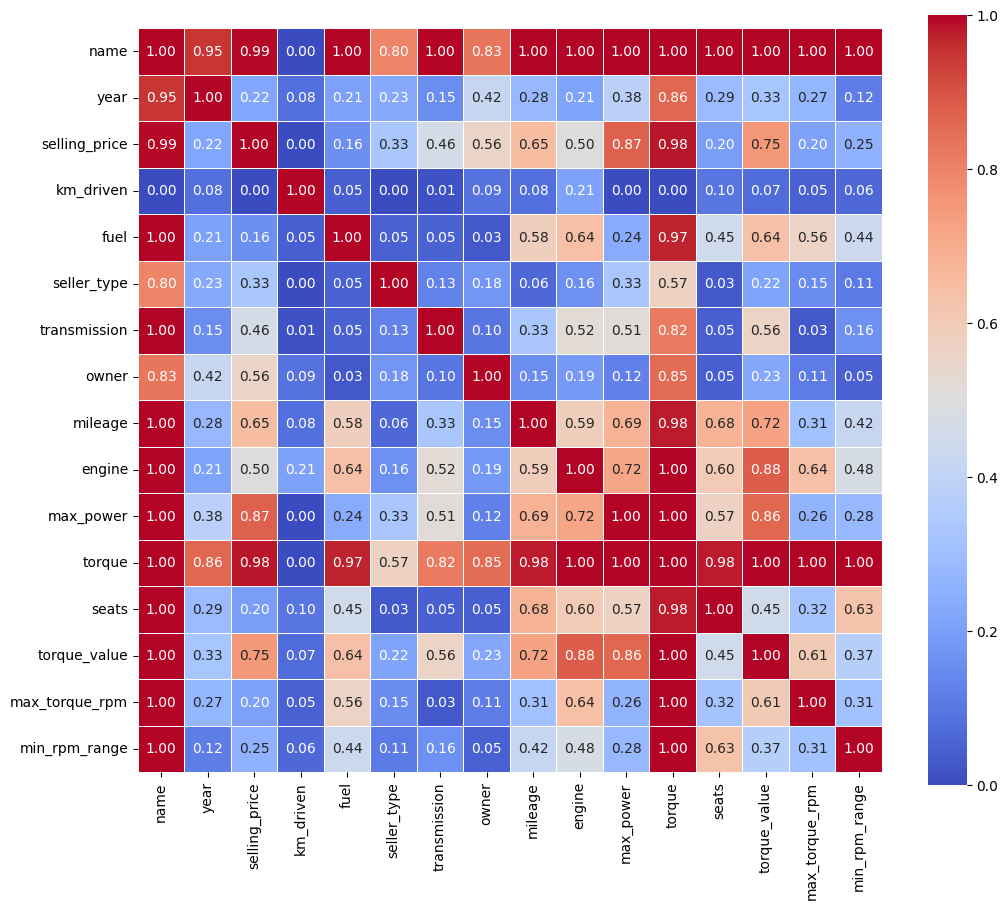

In [336]:
from phik import phik_matrix
import seaborn as sns
import matplotlib.pyplot as plt


phik_corr = df_train.phik_matrix()
plt.figure(figsize=(12, 10))
sns.heatmap(phik_corr, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, square=True, linewidths=0.5)
plt.show()

Всегда полезно изучить связь между переменными с помощью диаграммы рассеяния. Коэффициенты корреляции измеряют только линейные (Пирсона) или монотонные (Спирмена) отношения.

### **Дополнительные визуализации (бонус 0.2 балла)**

Если вам кажется, что мы не попросили вас нарисовать какие-то очень важные зависимости, нарисуйте их и поясните.

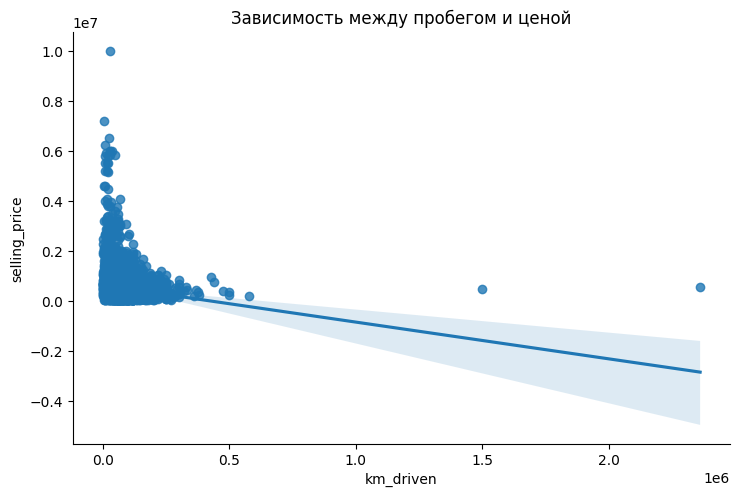

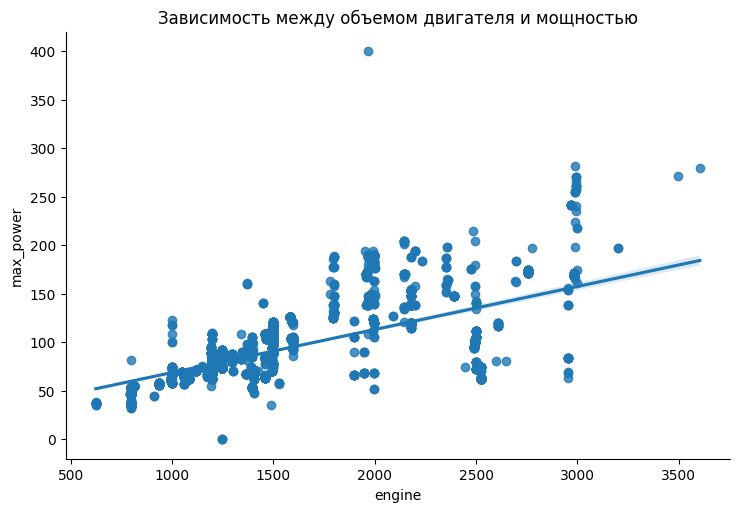

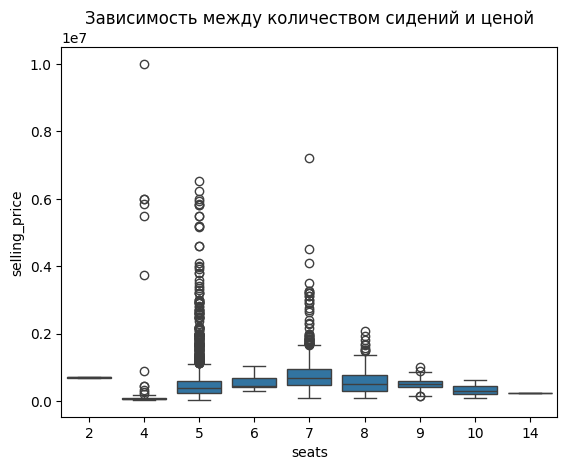

In [337]:
import matplotlib.pyplot as plt

sns.lmplot(x='km_driven', y='selling_price', data=df_train, aspect=1.5)
plt.title("Зависимость между пробегом и ценой")
plt.xlabel("km_driven")
plt.ylabel("selling_price")
plt.show()

sns.lmplot(x='engine', y='max_power', data=df_train, aspect=1.5)
plt.title("Зависимость между объемом двигателя и мощностью")
plt.xlabel("engine")
plt.ylabel("max_power")
plt.show()

sns.boxplot(x='seats', y='selling_price', data=df_train)
plt.title("Зависимость между количеством сидений и ценой")
plt.xlabel("seats")
plt.ylabel("selling_price")
plt.show()

1. На графике видно, что с увеличением пробега цена автомобиля обычно уменьшается.
2. Положительную корреляцию между объемом двигателя и максимальной мощностью. Это подтверждается графиком, на котором видно, что с увеличением объема двигателя мощность также растет
3. График показывает, как цена меняется в зависимости от количества сидений. Это может зависеть от типа автомобиля

/usr/local/lib/python3.10/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
<ipython-input-338-91b097ec15b6>:13: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend_dict = {h.get_label(): h for h in pg.legend.legendHandles}


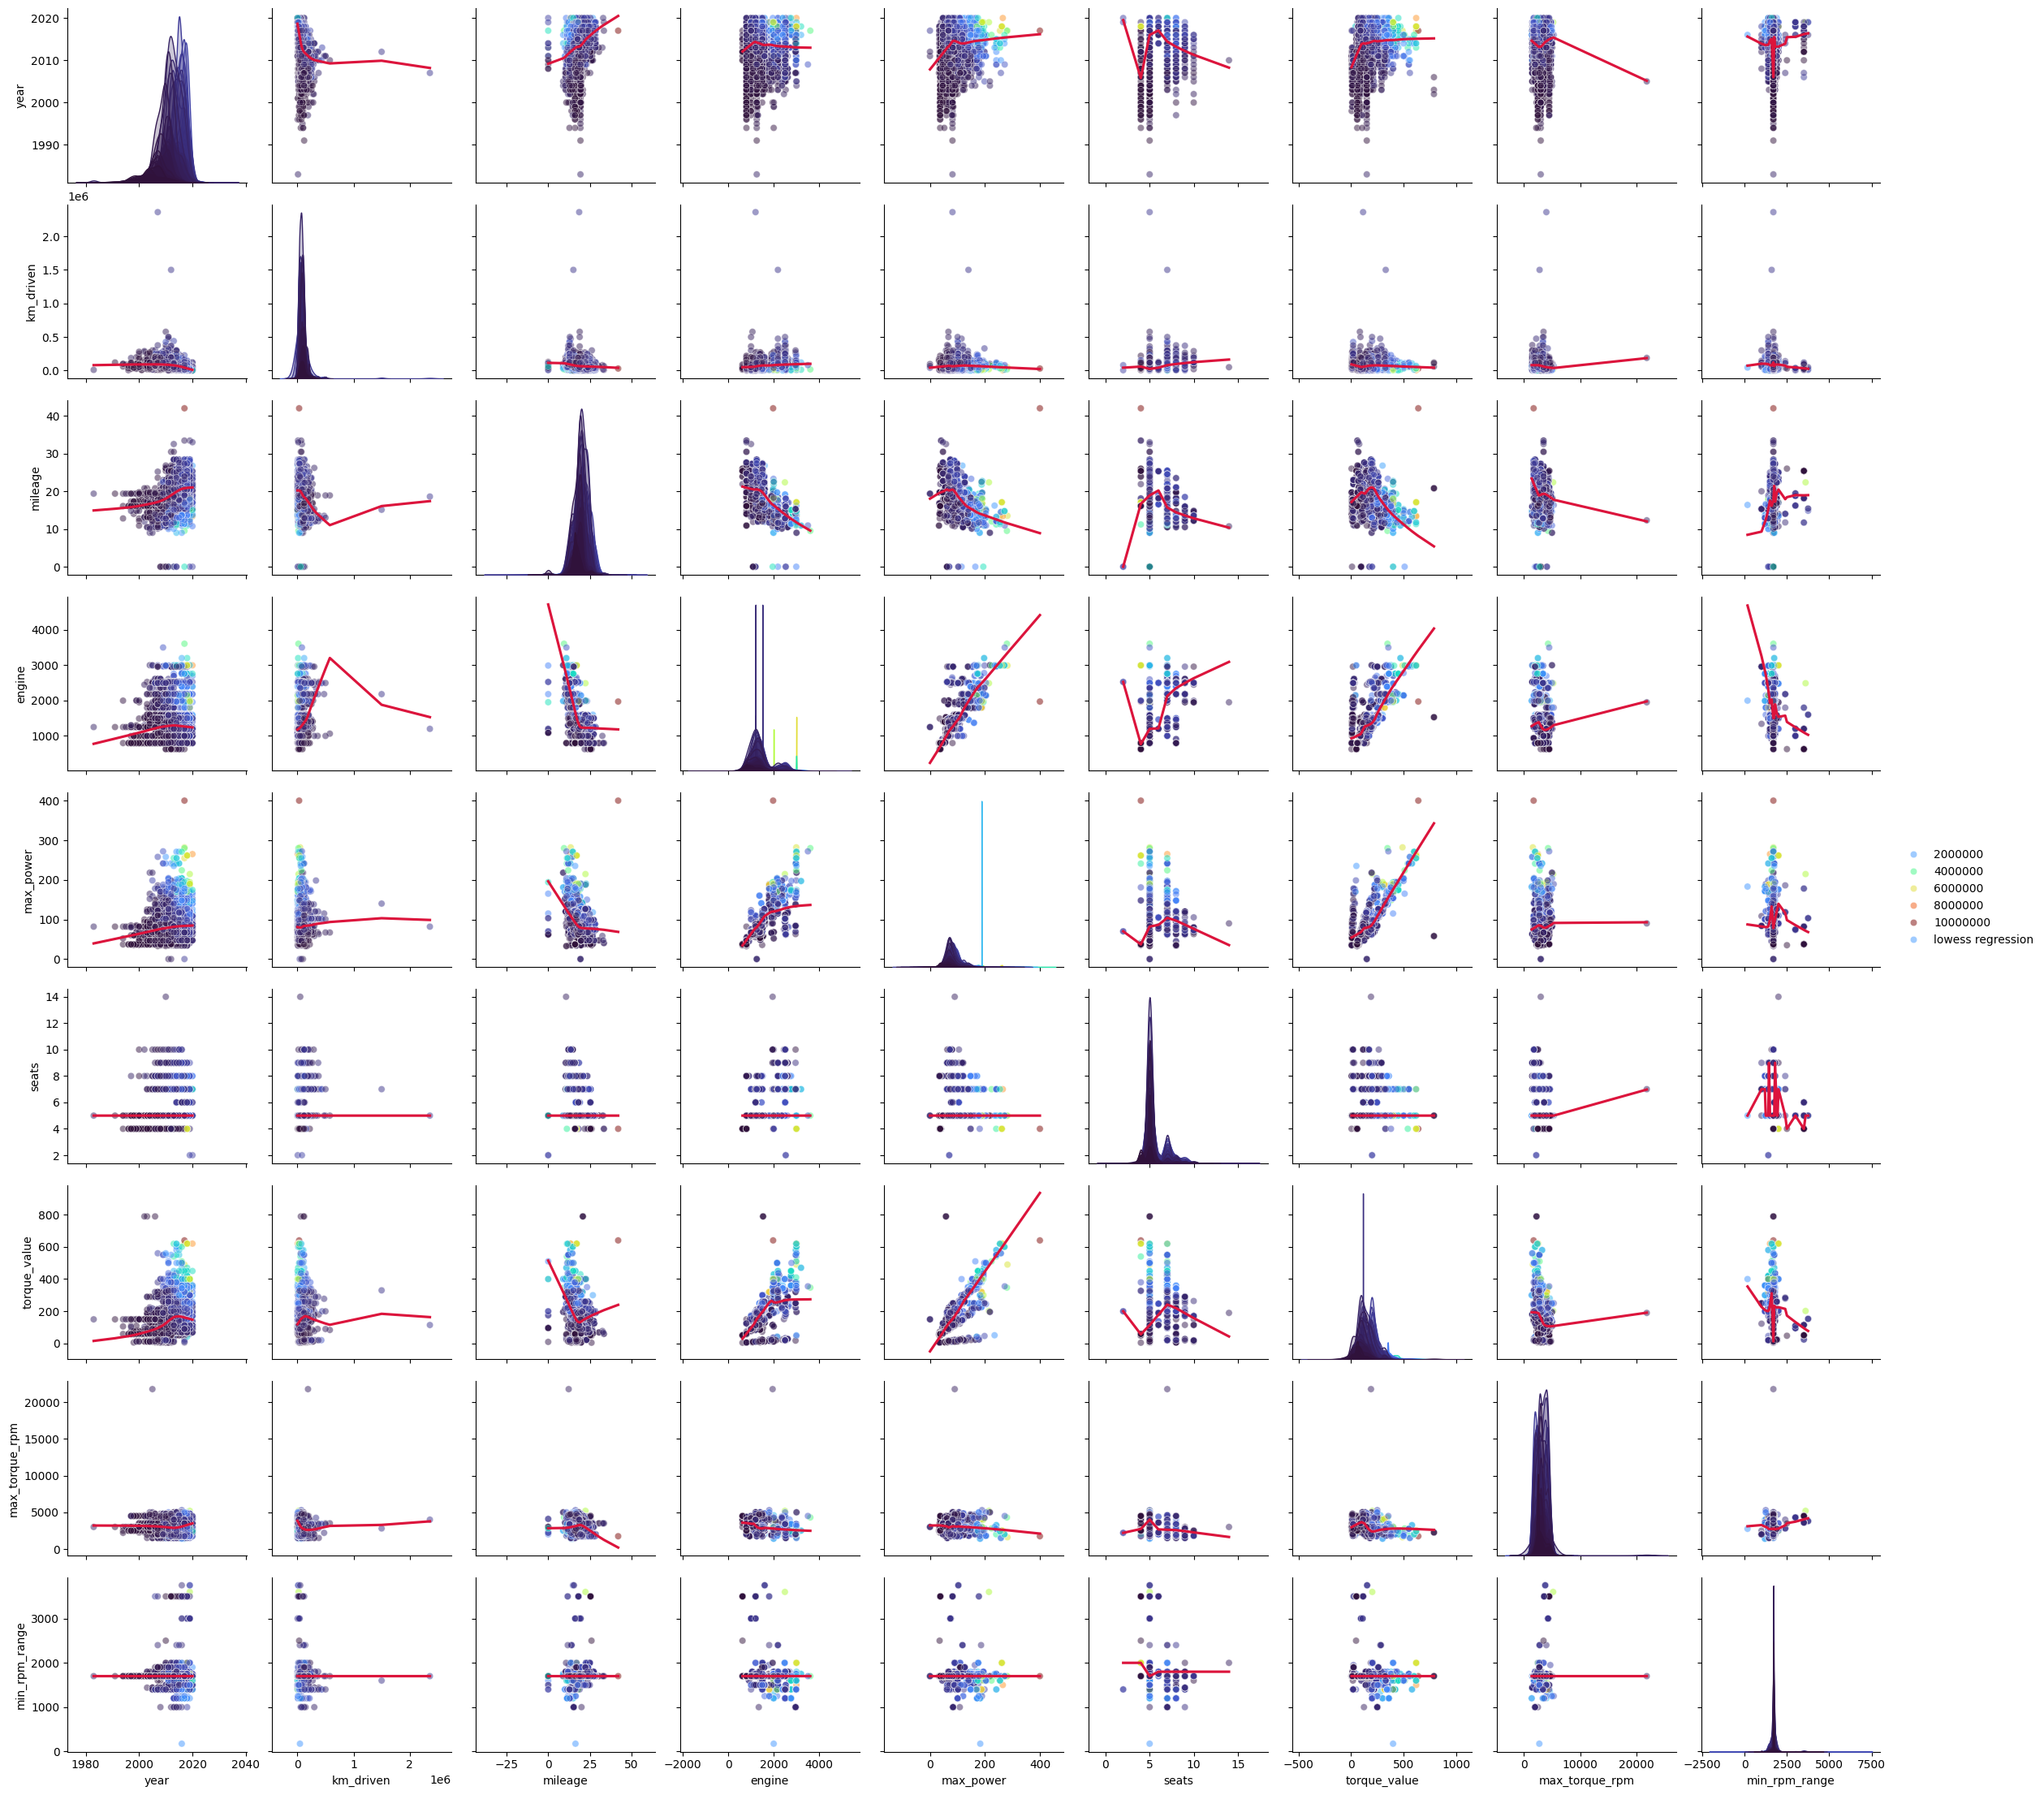

In [338]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_extra(x, y, **kwargs):
     if kwargs['label'] == first_label:
          sns.regplot(data=df_train, x=x.name, y=y.name, lowess=True, scatter=False, color=kwargs['color'])

first_label = df_train['selling_price'][0]
pg = sns.pairplot(df_train, hue='selling_price', plot_kws={'alpha': 0.5}, palette='turbo')

pg.map_offdiag(plot_extra, color='crimson', data=df_train)

legend_dict = {h.get_label(): h for h in pg.legend.legendHandles}
legend_dict['lowess regression'] = pg.axes[0, 1].lines[0]

pg.legend.remove()
pg.add_legend(legend_dict, label_order=legend_dict.keys(), title='')
plt.show()

pg.map вызывает plot_extra для каждого значения оттенка для каждого графика.

x и y: столбцы для этого подграфика, ограниченные текущим значением оттенка

Вот теперь явно видны зависимости на целевую переменную!

# **Часть 2 (1.7 балла) | Модель только на вещественных признаках**

В этой части вам предстоит обучить модель только на вещественных признаках. Почему только на них?

Чем больше признаковое пространство — чем сложнее модель. А чем модель проще — тем лучше для скорости работы и интерпретации признаков.

За задания этой части вы можете набрать 1.7 основных и 0.15 бонусных балла;

### **Задание 11 (0.05 балла)**

Разбейте данные на тренировочный и тестовый наборы. Перед разбиением создайте копию датафрейма, который будет хранить только вещественные признаки и используйте его (то есть категориальные столбцы (все, кроме seats) необходимо удалить).

В переменные y_train и y_test запишите значения целевых переменных.

In [339]:
y_train = df_train['selling_price'].copy()
X_train = df_train.select_dtypes(include=['float64', 'int64']).copy()
X_train.drop(columns=['selling_price','torque_value','max_torque_rpm','min_rpm_range'], inplace=True)

In [340]:
assert X_train.shape == (5840, 6)

In [341]:
y_test = df_test['selling_price'].copy()
X_test = df_test.select_dtypes(include=['float64', 'int64']).copy()
X_test.drop(columns=['selling_price','torque_value','max_torque_rpm','min_rpm_range'], inplace=True)

In [342]:
assert X_test.shape == (1000, 6)

In [343]:
y_train2 = df_train['selling_price'].copy()
X_train2 = df_train.select_dtypes(include=['float64', 'int64']).copy()
X_train2.drop(columns=['selling_price','torque_value','max_torque_rpm','min_rpm_range','km_driven','mileage','seats'], inplace=True)

y_test2 = df_test['selling_price'].copy()
X_test2 = df_test.select_dtypes(include=['float64', 'int64']).copy()
X_test2.drop(columns=['selling_price','torque_value','max_torque_rpm','min_rpm_range','km_driven','mileage','seats'], inplace=True)

### **Задание 12. (0.2 балла)**

Построим нашу первую модель!
- [ ] Обучите классическую линейную регрессию с дефолтными параметрами. Посчтитайте $R^2$ и $MSE$ для трейна и для теста.
- [ ] Сделайте выводы по значениям метрик качества.

**Примечание:**

Здесь и далее $R^2$ и $MSE$ для трейна и для теста выводите везде, где требуется обучать модели, даже если в явном виде этого не просят. Иначе непонятно, как понять, насколько успешны наши эксперименты.

In [344]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error as MSE

model_LinearRegression = LinearRegression()
model_LinearRegression.fit(X_train, y_train)
y_train_pred = model_LinearRegression.predict(X_train)
y_test_pred = model_LinearRegression.predict(X_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_train = MSE(y_train, y_train_pred)
mse_test = MSE(y_test, y_test_pred)

print("Train R²:", r2_train)
print("Test R²:", r2_test)
print("Train MSE:", mse_train)
print("Test MSE:", mse_test)

Train R²: 0.5922591702157316
Test R²: 0.5941419794788428
Train MSE: 116874153930.02855
Test MSE: 233298779730.45486


In [345]:
#pickle.dump(model_LinearRegression, open("model_LinearRegression.pkl", "wb"))

In [346]:
X_test.head()

year  km_driven  mileage  engine  max_power  seats
0  2010     168000     14.0    2498      112.0      7
1  2017      25000     21.5    1497      108.5      5
2  2007     218463     12.9    1799      130.0      5
3  2015     173000     25.1    1498       98.6      5
4  2011      70000     16.5    1172       65.0      5

1. Среднее качество модели
2. Значения R² на тестовой и тренировочной выборках очень близки друг к другу, что является хорошим признаком того, что модель не переобучена
3. MSE Test >> NSE Train: модель немного хуже предсказывает на новых данных
4. Высокие значения MSE могут говорить о том, что предсказания модели достаточно далеки от реальных значений

### **Задание 13 (0.15 балла)**

- [ ] Реализуйте $R^2$ руками. Приведите формулу $R^2$ и объясните каждую компоненту метрики

In [347]:
def r2(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_residual / ss_total)

r2(y_test, y_test_pred)

0.5941419794788428

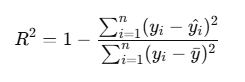

yi  - реальные значения целевой переменной

𝑦𝑖^ - предсказанные значения, полученные моделью

y-  - среднее значение всех реальных значений

n — количество наблюдений

Проходили на курсе Питона (Ассоль)

### **Бонус (0.15 балла)**

- [ ] Реализуйте [$\text{adjusted}-R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination).
- [ ] Объясните, когда применяется $\text{adjusted}-R^2$?

In [348]:
def adjusted_r2(y_true, y_pred, n, p):
    r2 = r2_score(y_true, y_pred)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    return adj_r2

n = len(y_train)
p = X_train.shape[1]

adj_r2_train = adjusted_r2(y_train, y_train_pred, n, p)
adj_r2_test = adjusted_r2(y_test, y_test_pred, n, p)

print(f"Adjusted R² Train: {adj_r2_train}")
print(f"Adjusted R² Test: {adj_r2_test}")

Adjusted R² Train: 0.5918397556814087
Adjusted R² Test: 0.5937245016590028


In [349]:
model = LinearRegression()
model.fit(X_train2, y_train2)
y_train_pred2 = model.predict(X_train2)
y_test_pred2 = model.predict(X_test2)
r2_train2 = r2_score(y_train2, y_train_pred2)
r2_test2 = r2_score(y_test2, y_test_pred2)

print("Train R²:", r2_train2)
print("Test R²:", r2_test2)

n = len(y_train2)
p = X_train2.shape[1]

adj_r2_train2 = adjusted_r2(y_train2, y_train_pred2, n, p)
adj_r2_test2 = adjusted_r2(y_test2, y_test_pred2, n, p)

print(f"Adjusted R² Train: {adj_r2_train2}")
print(f"Adjusted R² Test: {adj_r2_test2}")


Train R²: 0.5842429627931062
Test R²: 0.5802683270067164
Adjusted R² Train: 0.5840292425889217
Adjusted R² Test: 0.5800525636381455


Adjusted R2 = R2 - [(1- R2)*(p/n-p-1)]

Скорректированный R-квадрат сравнивает объяснительную силу регрессионных моделей, которые содержат разное количество признаков. Предположим, вы сравниваете модель с пятью признаками с более высоким R-квадрат с моделью с одним признаком. Имеет ли модель с пятью признаков более высокий R-квадрат, потому что она лучше? Или R-квадрат выше, потому что у нее больше признаков?

Просто сравнить скорректированные значения R-квадрата, чтобы узнать это

Скорректированный R-квадрат — это модифицированная версия R-квадрата, скорректированная с учетом количества признаков в модели.

Скорректированный R-квадрат увеличивается только в том случае, если новый признак улучшает модель больше, чем можно было бы ожидать случайно.

Он уменьшается, когда признак не улучшает модель, чем можно было бы ожидать случайно.

### **Задание 14 (0.05 балла)**

Всегда есть место совершенству. Поэтому давайте попробуем улучшить модель. При помощи стандартизации признаков.

- [ ] Стандартизируйте значения в тренировочных и тестовых данных. Стандартизатор **обучайте только на `train`**.

In [350]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_train_pred_scaled = model.predict(X_train_scaled)
y_test_pred_scaled = model.predict(X_test_scaled)
r2_train_scaled = r2_score(y_train, y_train_pred_scaled)
r2_test_scaled = r2_score(y_test, y_test_pred_scaled)

print("Train R²:", r2_train)
print("Test R²:", r2_test)

print("Train R²:", r2_train_scaled)
print("Test R²:", r2_test_scaled)

Train R²: 0.5922591702157316
Test R²: 0.5941419794788428
Train R²: 0.5922591702157303
Test R²: 0.594141979478852


### **Задание 15 (0.1 балла)**

Хотя стандартизация не помогла сильно прибавить в качестве она открыла возможность интерпретировать важность признаков в модели. Правило интерпретации такое:

Чем больше коэффициент $\beta_i$ по модулю, тем важнее признак.

**Ответьте на вопрос:**

- [ ] Какой признак оказался наиболее информативным в предсказании цены?

In [351]:
pd.DataFrame(model.coef_, index=X_train.columns, columns=['Coefficient']).abs().sort_values(by='Coefficient', ascending=False)

Coefficient
max_power  322807.353259
year       152772.570846
engine      61178.494337
km_driven   44158.818520
mileage     28833.925778
seats       23209.132486

max_power - наиболее информативным

### **Задание 16 (0.25 балла)**

Попробуем улучшить нашу модель с помощью применения регуляризации. Для этого воспльзуемся `Lasso` регрессией.  Кроме того, попробуйте использовать её теоретическое свойство отбора признаков, за счет зануления незначимых коэффициентов.

**Задание:**

- [ ] Обучите Lasso регрессию на тренировочном наборе данных с нормализованными признаками. Оцените её качество
- [ ] Проверьте, занулила ли L1-регуляризация с параметрами по умолчанию какие-нибудь веса? Предположите почему.

In [352]:
from sklearn.linear_model import LassoCV

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso_cv = LassoCV(cv=5, random_state=42)  # cv=5 - 5-кратная кросс-валидация
lasso_cv.fit(X_train_scaled, y_train)

lasso_cv.alpha_

1214.6057211408174

In [353]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error as MSE, r2_score

# Инициализация и обучение модели Lasso
lasso = Lasso(alpha=1214.0)  # alpha=1.0 - дефолтное значение
lasso.fit(X_train_scaled, y_train)

# Оценка качества модели
y_train_pred = lasso.predict(X_train_scaled)
y_test_pred = lasso.predict(X_test_scaled)

# Расчет R² и MSE
train_r2_lasso = r2_score(y_train, y_train_pred)
test_r2_lasso = r2_score(y_test, y_test_pred)

mse_train = MSE(y_train, y_train_pred)

print(f"Test R²: {r2_test_scaled}")
print(f"Test R²: {test_r2_lasso}")

print(f"MSE: {mse_train}")

Test R²: 0.594141979478852
Test R²: 0.5927036847273632
MSE: 116888691997.71085


In [354]:
pd.DataFrame(lasso.coef_, index=X_train.columns, columns=['Coefficient']).abs().sort_values(by='Coefficient', ascending=False), np.sum(lasso.coef_ == 0)

(             Coefficient
 max_power  323851.002067
 year       152514.372739
 engine      55416.082723
 km_driven   42813.636375
 mileage     26614.818621
 seats       19740.846691,
 0)

Lasso регрессия с параметрами по умолчанию (alpha=1) может занулить менее значимые признаки, улучшая интерпретируемость модели и снижая её сложность.

Увеличить значение alpha, чтобы усилить регуляризацию и увидеть, приведет ли это к занулению коэффициентов.

Если alpha слишком маленькое, регуляризация слабая, и модель будет работать как обычная линейная регрессия, не зануляя коэффициенты.
Чтобы заставить Lasso занулять больше коэффициентов, необходимо увеличить значение alpha

### **Задание 17. Финальный рывок (0.4 балла)**

До этого мы с вами использовали `train` для обучения и `test` для прогнозирования. Но у нас есть ещё одна задача — подобрать оптимальные параметры модели. Для этого используем кросс-валидацию, описанную на семинарах.

Кроме того, выжмем максимум из модификаций регрессии. Построим `ElasticNet`. И сделаем всё по порядку.

**Ваша задача 1:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для Lasso-регрессии. Вам пригодится класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
- [ ] Ответьте на вопросы:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Что значит каждый параметр `param_grid`, который вы заполняли для `GridSearch`? Опишите каждый
 - Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?

In [355]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {
    'alpha': np.logspace(-4, 4, 1000)
}

lasso = Lasso()

grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
y_train_pred_grid = grid_search.predict(X_train_scaled)
y_train_pred_grid = pd.DataFrame(y_train_pred_grid)
mse_train_grid = MSE(y_train, y_train_pred_grid)


print(f"Best alpha: {grid_search.best_params_['alpha']}")
print(f"Best score (Negative MSE): {grid_search.best_score_}")
print(f"MSE: {mse_train_grid}")

Best alpha: 1135.154708920999
Best score (Negative MSE): -121303403918.78104
MSE: 116886859757.03091


In [356]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error as MSE, r2_score

# Инициализация и обучение модели Lasso
lasso = Lasso(alpha=1135.0)  # alpha=1.0 - дефолтное значение
lasso.fit(X_train_scaled, y_train)

# Оценка качества модели
y_train_pred = lasso.predict(X_train_scaled)
y_test_pred = lasso.predict(X_test_scaled)

# Расчет R² и MSE
train_r2_lasso = r2_score(y_train, y_train_pred)
test_r2_lasso = r2_score(y_test, y_test_pred)

mse_test = MSE(y_test, y_test_pred)

print(f"Train R²: {train_r2_lasso}")
print(f"Test R²: {test_r2_lasso}")

print(f"MSE: {mse_test}")

Train R²: 0.5922148553025387
Test R²: 0.5927988759742386
MSE: 234070833978.07947


✈ Сколько грид-сёрчу пришлось обучать моделей?

1000(шаги)×10(количество фолдов)=10000

✈ Что значит каждый параметр param_grid, который вы заполняли для GridSearch?

Это параметр регуляризации Lasso, который контролирует степень наказания за сложность модели. При значении alpha = 0, Lasso превращается в обычную линейную регрессию без регуляризации. Чем больше значение alpha, тем сильнее регуляризация, и тем больше коэффициентов будут зануляться, что способствует уменьшению сложности модели.

✈ Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?

https://numpy.org/doc/stable/reference/generated/numpy.logspace.html
Выше предугадал вопрос и почистал при других параметрах alpha = 1214, при более точном подходе: alpha: 1135 +/- похоже и коефициенты не занулились

**Ваша задача 2:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) регрессии.
- [ ] Ответьте на вопрос:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Какие гиперпараметры соответствуют лучшей (по выбранной метрике качества) из перебранных моделей?

In [357]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

elastic_net = ElasticNet()

param_grid = {
    'alpha': np.logspace(-4, 4),  # Пробуем значения alpha от 1e-4 до 1e4
    'l1_ratio': np.linspace(0, 1, 11,1)  # Пробуем значения l1_ratio от 0 до 1
}

grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

print(f"ElasticNet Params {grid_search.best_params_}")
print(f"Best score (Negative MSE): {grid_search.best_score_}")
print("Коэффициенты для лучшей модели:", grid_search.best_estimator_.coef_)

# Оценка качества модели
y_train_pred = grid_search.predict(X_train_scaled)
y_test_pred = grid_search.predict(X_test_scaled)

train_r2_grid = r2_score(y_train, y_train_pred)
test_r2_grid = r2_score(y_test, y_test_pred)

r2_test = grid_search.score(X_test_scaled, y_test)
#mse_test = mean_squared_error(y_test, y_pred)

print(f"Train R²: {train_r2_grid}")
print(f"Test R²: {test_r2_grid}")

print(f"R² на тестовых данных: {r2_test}")
print(f"MSE на тестовых данных: {mse_test}")

ElasticNet Params {'alpha': 0.02811768697974228, 'l1_ratio': 0.5}
Best score (Negative MSE): -121286725433.14621
Коэффициенты для лучшей модели: [151949.3347188  -44617.90018561  27925.23903261  65432.97859481
 315504.5247161  -24149.236539  ]
Train R²: 0.5921545535163009
Test R²: 0.5910498643871229
R² на тестовых данных: -235076215782.49612
MSE на тестовых данных: 234070833978.07947


✈ Сколько грид-сёрчу пришлось обучать моделей?
50(alpha)*11(li_ratio)*10(holds) = 5500
✈ Какие гиперпараметры соответствуют лучшей (по выбранной метрике качества) из перебранных моделей?

ElasticNet Params {'alpha': 0.02811768697974228, 'l1_ratio': 0.5}

### **Задание 18 (0.35 балла)**

И так, вы обучили все варианты регуляризаций, доступные в sklearn, но не все, что мы обсудили на занятии! И следующее задание о забытой - $L0$ регуляризации.


**Ваша задача:**>
- [ ] Реализуйте модель с $L0$-регуляризаицей.
- [ ] Обучите модель на данных и проанализируйте результат, экспериментируя с коэффициенитом регуляризации
- [ ] Проанализируйте результаты обучения

**Важно:**

Вопреки тому, что L0 не реализована в стандартных пакетах, концепция данной регуляризации не является мертвой. Она может встречаться в [статьях](https://arxiv.org/abs/1712.01312) и экспериментах.



In [358]:
lasso = Lasso(alpha=0.01)
lasso.fit(X_train_scaled, y_train)

lasso_coef = lasso.coef_

selected_features = np.where(lasso_coef != 0)[0]

X_train_l0 = X_train_scaled[:, selected_features]
X_test_l0 = X_test_scaled[:, selected_features]

# Обучаем модель на отобранных признаках
model = LinearRegression()
model.fit(X_train_l0, y_train)

# Оценка модели
train_r2 = model.score(X_train_l0, y_train)
test_r2 = model.score(X_test_l0, y_test)

train_mse = mean_squared_error(y_train, model.predict(X_train_l0))
test_mse = mean_squared_error(y_test, model.predict(X_test_l0))

print(f"Train R²: {train_r2}")
print(f"Test R²: {test_r2}")
print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")

Train R²: 0.5922591702157303
Test R²: 0.594141979478852
Train MSE: 116874153930.02892
Test MSE: 233298779730.44965


In [359]:
alphas = np.logspace(-5, 5, 50)
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train_scaled, y_train)
    y_pred = lasso.predict(X_test_scaled)
    y_test_pred = lasso.predict(X_test_scaled)

    selected_features = np.where(lasso.coef_ != 0)[0]
    print(f"Alpha: {alpha}, Количество отобранных признаков: {len(selected_features)} R2 {r2_score(y_test, y_test_pred)} MSE {mean_squared_error(y_test, y_test_pred)}")

Alpha: 1e-05, Количество отобранных признаков: 6 R2 0.5941419794674578 MSE 233298779736.9993
Alpha: 1.5998587196060572e-05, Количество отобранных признаков: 6 R2 0.5941419794605742 MSE 233298779740.9562
Alpha: 2.559547922699533e-05, Количество отобранных признаков: 6 R2 0.5941419794494046 MSE 233298779747.3768
Alpha: 4.094915062380427e-05, Количество отобранных признаков: 6 R2 0.5941419794316593 MSE 233298779757.57736
Alpha: 6.55128556859551e-05, Количество отобранных признаков: 6 R2 0.5941419794030702 MSE 233298779774.01114
Alpha: 0.00010481131341546853, Количество отобранных признаков: 6 R2 0.5941419793574789 MSE 233298779800.21832
Alpha: 0.00016768329368110083, Количество отобранных признаков: 6 R2 0.5941419792844582 MSE 233298779842.1927
Alpha: 0.0002682695795279727, Количество отобранных признаков: 6 R2 0.5941419791673885 MSE 233298779909.4877
Alpha: 0.00042919342601287783, Количество отобранных признаков: 6 R2 0.5941419789802146 MSE 233298780017.08066
Alpha: 0.0006866488450042998

Использовали Lasso с разными значениями alpha для отбора признаков. Чем выше значение alpha, тем больше коэффициентов будет занулено.

Оценивали модель после каждого изменения значения alpha на тренировочных и тестовых данных, вычисляя метрики R2

При слишком низком alpha (например, 0.01), модель использует все признаки, что может привести к переобучению, особенно если данных слишком мало или признаки сильно коррелируют.

При большем alpha модель становится более обобщенной, так как удаляет незначительные признаки, что может привести к увеличению Test R² и снижению Train R², что говорит о лучшем обобщении модели.

# **Часть 3 (0.5 балла) | Добавляем категориальные фичи**

Попробуем для улучшения модели дать ей больше признаков. Добавим категориальные фичи.

За эту часть можно набрать 0.5 основных балла.



### **Задание 19 (0.1 балла)**

Проанализируйте столбец `name`. Очевидно, что эта переменная является категориальной, однако категорий в ней много.

- [ ] Предобработайте столбец `name`, чтобы избежать его удаления

In [360]:
df_train['brand'] = df_train['name'].str.split(' ').str[0]
df_test['brand'] = df_test['name'].str.split(' ').str[0]

In [361]:
X_train_cat = df_train
X_test_cat = df_train

In [362]:
X_train_cat = X_train_cat.drop(columns=['fuel','seller_type','transmission','owner','torque','min_rpm_range'])
X_test_cat = X_test_cat.drop(columns=['fuel','seller_type','transmission','owner','torque','min_rpm_range'])

In [363]:
df_train['brand'].unique()

array(['Maruti', 'Skoda', 'Hyundai', 'Toyota', 'Ford', 'Renault',
       'Mahindra', 'Honda', 'Chevrolet', 'Fiat', 'Datsun', 'Tata', 'Jeep',
       'Mercedes-Benz', 'Mitsubishi', 'Audi', 'Volkswagen', 'BMW',
       'Nissan', 'Lexus', 'Jaguar', 'Land', 'MG', 'Volvo', 'Daewoo',
       'Kia', 'Force', 'Ambassador', 'Isuzu', 'Peugeot'], dtype=object)

In [364]:
assert X_train_cat.shape == (5840, 11)

In [ ]:
#Странный тест, ну ладно

In [365]:
X_train_cat.describe(include='object')

name   brand
count                     5840    5840
unique                    1924      30
top     Maruti Swift Dzire VDI  Maruti
freq                        91    1804

### **Задание 20 (0.1 балла)**

- [ ] Закодируйте категориалльные фичи и ``seats`` методом OneHot-кодирования.

In [366]:
df_train.head()

name  year  selling_price  km_driven    fuel  \
0         Maruti Swift Dzire VDI  2014         450000     145500  Diesel   
1   Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel   
2      Hyundai i20 Sportz Diesel  2010         225000     127000  Diesel   
3         Maruti Swift VXI BSIII  2007         130000     120000  Petrol   
4  Hyundai Xcent 1.2 VTVT E Plus  2017         440000      45000  Petrol   

  seller_type transmission         owner  mileage  engine  max_power  \
0  Individual       Manual   First Owner    23.40    1248      74.00   
1  Individual       Manual  Second Owner    21.14    1498     103.52   
2  Individual       Manual   First Owner    23.00    1396      90.00   
3  Individual       Manual   First Owner    16.10    1298      88.20   
4  Individual       Manual   First Owner    20.14    1197      81.86   

                     torque  seats  torque_value  max_torque_rpm  \
0            190Nm@ 2000rpm      5        190.00          2000.0   
1       250Nm@ 1500-2500rpm      5        250.00          2500.0   
2  22.4 kgm at 1750-2750rpm      5         22.40          2750.0   
3     11.5@ 4,500(kgm@ rpm)      5         11.50          4500.0   
4         113.75nm@ 4000rpm      5        113.75          4000.0   

   min_rpm_range    brand  
0         1700.0   Maruti  
1         1500.0    Skoda  
2         1750.0  Hyundai  
3         1700.0   Maruti  
4         1700.0  Hyundai

In [367]:
X_train_cat = df_train.drop(columns=['name','selling_price','torque','min_rpm_range'])
X_test_cat = df_test.drop(columns=['name','selling_price','torque','min_rpm_range'])

In [368]:
df_train['fuel'].unique()

array(['Diesel', 'Petrol', 'LPG', 'CNG'], dtype=object)

In [369]:
X_train_encoded = pd.get_dummies(X_train_cat, columns=['fuel','seller_type','transmission','owner','seats','brand'], drop_first=True)
X_test_encoded = pd.get_dummies(X_test_cat, columns=['fuel','seller_type','transmission','owner','seats','brand'], drop_first=True)
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

In [370]:
print(X_train_encoded.head().to_string())

   year  km_driven  mileage  engine  max_power  torque_value  max_torque_rpm  fuel_Diesel  fuel_LPG  fuel_Petrol  seller_type_Individual  seller_type_Trustmark Dealer  transmission_Manual  owner_Fourth & Above Owner  owner_Second Owner  owner_Test Drive Car  owner_Third Owner  seats_4  seats_5  seats_6  seats_7  seats_8  seats_9  seats_10  seats_14  brand_Audi  brand_BMW  brand_Chevrolet  brand_Daewoo  brand_Datsun  brand_Fiat  brand_Force  brand_Ford  brand_Honda  brand_Hyundai  brand_Isuzu  brand_Jaguar  brand_Jeep  brand_Kia  brand_Land  brand_Lexus  brand_MG  brand_Mahindra  brand_Maruti  brand_Mercedes-Benz  brand_Mitsubishi  brand_Nissan  brand_Peugeot  brand_Renault  brand_Skoda  brand_Tata  brand_Toyota  brand_Volkswagen  brand_Volvo
0  2014     145500    23.40    1248      74.00        190.00          2000.0         True     False        False                    True                         False                 True                       False               False             

### **Задание 21 (0.2 балла)**

OHE — базовый алгоритм преобразования категориальных признаков, но и с ним нужно быть аккуратными.

**Ответьте на вопросы:**


* Как корректно работать с OHE преобразованием?
* Почему мы удаляем один столбец?
* Пусть из $n$ признаков мы получили $n-1$ столбец, из которых $k < n -1$ оказались не важными по весам модели. Корректно ли их удалить?

1. Однако важно помнить, что OHE увеличивает размерность данных

2. Проверить тип строковый или категориальный

3. На тренировочных данных и тестовых данных нужно обучать трансформер только на тренировочных данных

4. Когда мы применяем One-Hot Encoding, для каждого уникального значения категории создается отдельный столбец. Однако, чтобы избежать проблемы мультиколлинеарности (когда признаки сильно коррелируют друг с другом), мы обычно удаляем один столбец drop='first'

5. Удаление неважных признаков после OHE должно быть обоснованным и учитывать тип модели, которую вы используете

6. В деревьях решений и ансамблях деревьев признаки могут быть важными, даже если их веса малы в линейной модели, и удаление таких признаков может ухудшить качество модели.



### **Задание 22 (0.1 балла)**
Повторим то, что делали на прошлом шаге для моделей на вещественных признаках, однако теперь с моделью `Ridge`.


**Ваша задача:**
- [ ] Переберите параметр регуляризации `alpha` для гребневой (ridge) регрессии с помощью класса `GridSearchCV` В качестве параметров при объявлении GridSearchCV кроме модели укажите метрику качества $R^2$. Кроссвалидируйтесь по 10-ти фолдам.
- [ ] Ответье на вопрос: Удалось ли улучшить качество прогнозов?

In [371]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': np.logspace(-4, 4, 50)}

ridge = Ridge()
grid_search_ridge = GridSearchCV(ridge, param_grid, cv=10, scoring='r2', n_jobs=-1)

grid_search_ridge.fit(X_train_scaled, y_train)
best_alpha = grid_search_ridge.best_params_['alpha']
print(f"alpha: {best_alpha}")

best_model = grid_search_ridge.best_estimator_

y_train_pred = best_model.predict(X_train_scaled)
train_r2 = r2_score(y_train, y_train_pred)
y_test_pred = best_model.predict(X_test_scaled)
test_r2 = r2_score(y_test, y_test_pred)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"Train R²: {train_r2}")
print(f"Test R²: {test_r2}")
print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")

alpha: 719.6856730011514
Train R²: 0.5866875594973591
Test R²: 0.567226643198993
Train MSE: 118471191168.31984
Test MSE: 248770483608.72403


poly_features рулит!!

In [373]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

pipeline = Pipeline([
('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
('scaler', StandardScaler()),
('linear_regression', LinearRegression())
])

pipeline.fit(X_train, y_train)
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_train = MSE(y_train, y_train_pred)
mse_test = MSE(y_test, y_test_pred)

r2_train, r2_test, mse_train, mse_test

(0.815509254555483, 0.8307014870560306, 52882120716.62421, 97317619667.31839)

Явного улучшения не произошло

In [374]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': np.logspace(-4, 4, 50)}

ridge = Ridge()
grid_search_ridge = GridSearchCV(ridge, param_grid, cv=10, scoring='r2', n_jobs=-1)
X_train_encoded = X_train_encoded.select_dtypes(include=['float64','int64', 'bool'])
X_test_encoded = X_test_encoded.select_dtypes(include=['float64','int64', 'bool'])
grid_search_ridge.fit(X_train_encoded, y_train)
best_alpha = grid_search_ridge.best_params_['alpha']
print(f"alpha: {best_alpha}")

best_model = grid_search_ridge.best_estimator_

y_train_pred = best_model.predict(X_train_encoded)
train_r2 = r2_score(y_train, y_train_pred)
y_test_pred = best_model.predict(X_test_encoded)
test_r2 = r2_score(y_test, y_test_pred)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"Train R²: {train_r2}")
print(f"Test R²: {test_r2}")
print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")

alpha: 1.7575106248547894
Train R²: 0.7707347819491611
Test R²: 0.7786844392427775
Train MSE: 65716201145.351006
Test MSE: 127218504130.3866


In [ ]:
#подключили категориальные фичи, улучшение произошло!

In [375]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error as MSE
X_train_encoded = X_train_encoded.select_dtypes(include=['float64','int64', 'bool'])
X_test_encoded = X_test_encoded.select_dtypes(include=['float64','int64', 'bool'])
model = LinearRegression()
model.fit(X_train_encoded, y_train)
y_train_pred = model.predict(X_train_encoded)
y_test_pred = model.predict(X_test_encoded)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_train = MSE(y_train, y_train_pred)
mse_test = MSE(y_test, y_test_pred)

r2_train, r2_test, mse_train, mse_test

(0.7768935952869902, 0.7886196196851786, 63950849123.93928, 121507478706.67384)

In [376]:
X_train_cat = df_train.drop(columns=['name','selling_price','torque','min_rpm_range'])
X_test_cat = df_test.drop(columns=['name','selling_price','torque','min_rpm_range'])

In [377]:
X_train_encoded = pd.get_dummies(X_train_cat, columns=['seats'], drop_first=True)
X_test_encoded = pd.get_dummies(X_test_cat, columns=['seats'], drop_first=True)
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

In [378]:
X_train_cat

year  km_driven    fuel seller_type transmission                 owner  \
0     2014     145500  Diesel  Individual       Manual           First Owner   
1     2014     120000  Diesel  Individual       Manual          Second Owner   
2     2010     127000  Diesel  Individual       Manual           First Owner   
3     2007     120000  Petrol  Individual       Manual           First Owner   
4     2017      45000  Petrol  Individual       Manual           First Owner   
...    ...        ...     ...         ...          ...                   ...   
5835  2008     191000  Petrol  Individual       Manual           First Owner   
5836  2013      50000  Petrol  Individual       Manual          Second Owner   
5837  2013     110000  Petrol  Individual       Manual           First Owner   
5838  2007     119000  Diesel  Individual       Manual  Fourth & Above Owner   
5839  2009     120000  Diesel  Individual       Manual           First Owner   

      mileage  engine  max_power  seats  torque_value  max_torque_rpm    brand  
0       23.40    1248      74.00      5        190.00          2000.0   Maruti  
1       21.14    1498     103.52      5        250.00          2500.0    Skoda  
2       23.00    1396      90.00      5         22.40          2750.0  Hyundai  
3       16.10    1298      88.20      5         11.50          4500.0   Maruti  
4       20.14    1197      81.86      5        113.75          4000.0  Hyundai  
...       ...     ...        ...    ...           ...             ...      ...  
5835    17.92    1086      62.10      5         96.10          3000.0  Hyundai  
5836    18.90     998      67.10      5         90.00          3500.0   Maruti  
5837    18.50    1197      82.85      5        113.70          4000.0  Hyundai  
5838    16.80    1493     110.00      5         24.00          2750.0  Hyundai  
5839    19.30    1248      73.90      5        190.00          2000.0   Maruti  

[5840 rows x 13 columns]

In [379]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
import pandas as pd

categorical_columns = ['fuel','seller_type','transmission','owner','seats','brand']
numerical_columns = X_train_cat.select_dtypes(include=['number']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_columns)
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('linear_regression', LinearRegression())
])

pipeline.fit(X_train_cat, y_train)
feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_columns)
X_test_aligned = X_test_cat.copy()

for col in feature_names:
    if col not in X_test_aligned.columns:
        X_test_aligned[col] = 0

X_test_aligned[feature_names] = X_test_aligned[feature_names]

y_train_pred = pipeline.predict(X_train_cat)
y_test_pred = pipeline.predict(X_test_aligned)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_train = MSE(y_train, y_train_pred)
mse_test = MSE(y_test, y_test_pred)

r2_train, r2_test, mse_train, mse_test

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


(0.9513896054566903, 0.9550183860502612, 13933602718.81557, 25856716177.014423)

In [395]:
X_train_cat = df_train.drop(columns=['selling_price','torque','min_rpm_range'])
X_test_cat = df_test.drop(columns=['selling_price','torque','min_rpm_range'])

In [391]:
#ухудшение
#X_train_cat['power_per_liter'] = X_train_cat['max_power'] / X_train_cat['engine']
#X_test_cat['power_per_liter'] = X_test_cat['max_power'] / X_test_cat['engine']

#X_train_cat['year_squared'] = X_train_cat['year'] ** 2
#X_test_cat['year_squared'] = X_test_cat['year'] ** 2

#X_train_cat['year_engine'] = X_train_cat['year'] * X_train_cat['engine']
#X_test_cat['year_engine'] = X_test_cat['year'] * X_test_cat['engine']

In [396]:
X_train_cat['car_type'] = X_train_cat['name'].apply(extract_car_info)
X_test_cat['car_type'] = X_test_cat['name'].apply(extract_car_info)

In [397]:
X_train_cat = df_train.drop(columns=['name'])
X_test_cat = df_test.drop(columns=['name'])

In [402]:
#ухудшение
#X_train_cat['owner_is_third_or_more'] = X_train_cat['owner'].apply(lambda x: 1 if 'third' in x.lower() or 'more' in x.lower() else 0)
#X_train_cat['first_or_second_owner_and_dealer'] = X_train_cat.apply(lambda row: 1 if ('First Owner' in row['owner'] or 'Second Owner' in row['owner']) and 'Dealer' in row['seller_type'] else 0, axis=1)
#X_test_cat['owner_is_third_or_more'] = X_test_cat['owner'].apply(lambda x: 1 if 'third' in x.lower() or 'more' in x.lower() else 0)
#X_test_cat['first_or_second_owner_and_dealer'] = X_test_cat.apply(lambda row: 1 if ('First Owner' in row['owner'] or 'Second Owner' in row['owner']) and 'Dealer' in row['seller_type'] else 0, axis=1)

In [401]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
import pandas as pd

categorical_columns = ['fuel','seller_type','transmission','owner','seats','brand']
numerical_columns = X_train_cat.select_dtypes(include=['number']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_columns)
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('linear_regression', LinearRegression())
])

pipeline.fit(X_train_cat, y_train)
feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_columns)
X_test_aligned = X_test_cat.copy()

for col in feature_names:
    if col not in X_test_aligned.columns:
        X_test_aligned[col] = 0

X_test_aligned[feature_names] = X_test_aligned[feature_names]

y_train_pred = pipeline.predict(X_train_cat)
y_test_pred = pipeline.predict(X_test_aligned)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_train = MSE(y_train, y_train_pred)
mse_test = MSE(y_test, y_test_pred)

r2_train, r2_test, mse_train, mse_test
#(0.9999999276384881, 0.9999997633907224, 20741.583535037436, 136009.7692800738)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


(0.9999999358124183, 0.9999990272514763, 18398.621749336817, 559163.6288651953)

## **Самый лучший результат!**

# **Часть 4 - бонусная (1 балл) | Feature Engineering**

В этой части домашнего задания вам предлагается проявить свою креативность для улучшения прогноза модели. Любые другие модели, кроме различных форм линейной (или полиномиальной) регресси, использовать запрещается. А значит, придется работать с признаками

**Что можно попробовать сделать?** (каждый пункт по 0.4 балла, но не больше 2-х баллов в сумме)

1.   *Сгенерировать новые признаки на основе уже существующих:*
    * посчитать произведения // частные признаков (кажется, что посчитать число "лошадей" на литр объема может быть полезно);
    * имеет смысл обратить внимание на визуализации в части с EDA (к примеру, зависимость цены от года выглядит квадратичной, а не линейной; значит, квадрат года нам, скорее всего, принесет больше пользы)

2.   *Добыть новые признаки:*
    * имеем название автомобиля, которое никак не используем (можно спарсить инфу о классе автомобиля или каких-то специфических опциях)
    * можно добавить пороговые признаки вроде "владелец третий или больше" и объединить признаки в некоторые осмысленные правила, например "первый или второй владелец и продавец официальный дилер" (подбирать пороги удобно по диаграммам рассеяния)

3.   *Поработать с уже имеющимися:*
    * далеко не факт, что заполнить пропуск медианой было лучшей идеей (как минимум, можно добавить dummy-столбец для модели, сигнализирующий, что раньше на месте медианы был пропуск -- там где он был, конечно); попробуйте другие способы филлинга;
    * мы не анализировали, есть ли в данных выбросы => никак выбросы не обрабатывали; наиболее простым и, тем не менее, довольно полезным вариантом нахождения выбросов могут послужить boxplot'ы для каждого столбца; что делать с выбросами думайте сами :) -- вариантов довольно много
    * мы толком не смотрели на таргет сам по себе; в нем тоже могут быть неожиданности -- стоит хотя бы проверить
    * можно заметить, что некоторые признаки распределены совсем не нормально; возможно их стоит отлогарифмировать

И так далее...

Feel Free to Try!

In [405]:
X_train_cat = df_train.drop(columns=['name','selling_price','torque'])
X_test_cat = df_test.drop(columns=['name','selling_price','torque'])

добавим добытую фичу min_rpm_range

In [406]:
df_train_encoded2 = pd.get_dummies(X_train_cat, columns=['fuel','seller_type','transmission','owner','seats','brand'], drop_first=True)
df_test_encoded2 = pd.get_dummies(X_test_cat, columns=['fuel','seller_type','transmission','owner','seats','brand'], drop_first=True)
df_train_encoded2, df_test_encoded2 = df_train_encoded2.align(df_test_encoded2, join='left', axis=1, fill_value=0)

In [407]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error as MSE

model = LinearRegression()
model.fit(df_train_encoded2, y_train)
y_train_pred = model.predict(df_train_encoded2)
y_test_pred = model.predict(df_test_encoded2)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_train = MSE(y_train, y_train_pred)
mse_test = MSE(y_test, y_test_pred)

r2_train, r2_test, mse_train, mse_test

(0.7779996233610943, 0.7874631338718338, 63633819074.6009, 122172259776.37521)

In [408]:
df_train_encoded2['power_per_liter'] = df_train_encoded2['max_power'] / df_train_encoded2['engine']
df_test_encoded2['power_per_liter'] = df_test_encoded2['max_power'] / df_test_encoded2['engine']

In [409]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error as MSE

model = LinearRegression()
model.fit(df_train_encoded2, y_train)
y_train_pred = model.predict(df_train_encoded2)
y_test_pred = model.predict(df_test_encoded2)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_train = MSE(y_train, y_train_pred)
mse_test = MSE(y_test, y_test_pred)

r2_train, r2_test, mse_train, mse_test

(0.7787882565789548,
 0.7893474447252511,
 63407766559.459526,
 121089104090.13152)

In [421]:
df_train_encoded2['year_squared'] = df_train_encoded2['year'] ** 2
df_test_encoded2['year_squared'] = df_test['year'] ** 2

In [422]:
model = LinearRegression()
model.fit(df_train_encoded2, y_train)
y_train_pred = model.predict(df_train_encoded2)
y_test_pred = model.predict(df_test_encoded2)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_train = MSE(y_train, y_train_pred)
mse_test = MSE(y_test, y_test_pred)

r2_train, r2_test, mse_train, mse_test

(0.8260050800441863, 0.8156302227485693, 49873614738.84793, 105981012760.82161)

In [423]:
df_train_encoded2['year_engine'] = df_train_encoded2['year'] * df_train_encoded2['engine']
df_test_encoded2['year_engine'] = df_test_encoded2['year'] * df_test_encoded2['engine']


In [424]:
model = LinearRegression()
model.fit(df_train_encoded2, y_train)
y_train_pred = model.predict(df_train_encoded2)
y_test_pred = model.predict(df_test_encoded2)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_train = MSE(y_train, y_train_pred)
mse_test = MSE(y_test, y_test_pred)

r2_train, r2_test, mse_train, mse_test

(0.8260050800441863, 0.8156302227485693, 49873614738.84793, 105981012760.82161)

In [425]:
def extract_car_info(name):
    # Пример: пытаемся выделить класс автомобиля
    # Создадим категориальные признаки на основе модели автомобиля, например, седан, хэтчбек и т.д.

    # Простейшее правило для классификации (можно расширить)
    if 'sedan' in name.lower():
        return 'sedan'
    elif 'hatchback' in name.lower():
        return 'hatchback'
    elif 'suv' in name.lower() or 'muv' in name.lower():
        return 'suv'
    elif 'convertible' in name.lower():
        return 'convertible'
    else:
        return 'other'

In [426]:
df_train['car_type'] = df_train['name'].apply(extract_car_info)
df_test['car_type'] = df_train['name'].apply(extract_car_info)

df_train['owner_is_third_or_more'] = df_train['owner'].apply(lambda x: 1 if 'third' in x.lower() or 'more' in x.lower() else 0)
df_train['first_or_second_owner_and_dealer'] = df_train.apply(lambda row: 1 if ('First Owner' in row['owner'] or 'Second Owner' in row['owner']) and 'Dealer' in row['seller_type'] else 0, axis=1)
df_test['owner_is_third_or_more'] = df_test['owner'].apply(lambda x: 1 if 'third' in x.lower() or 'more' in x.lower() else 0)
df_test['first_or_second_owner_and_dealer'] = df_test.apply(lambda row: 1 if ('First Owner' in row['owner'] or 'Second Owner' in row['owner']) and 'Dealer' in row['seller_type'] else 0, axis=1)

X_train_cat = df_train.drop(columns=['name','selling_price','torque'])
X_test_cat = df_test.drop(columns=['name','selling_price','torque'])

df_train_encoded2 = pd.get_dummies(X_train_cat, columns=['fuel','seller_type','transmission','owner','seats','brand','car_type'], drop_first=True)
df_test_encoded2 = pd.get_dummies(X_test_cat, columns=['fuel','seller_type','transmission','owner','seats','brand','car_type'], drop_first=True)
df_train_encoded2, df_test_encoded2 = df_train_encoded2.align(df_test_encoded2, join='left', axis=1, fill_value=0)

df_train_encoded2['power_per_liter'] = df_train_encoded2['max_power'] / df_train_encoded2['engine']
df_test_encoded2['power_per_liter'] = df_test_encoded2['max_power'] / df_test_encoded2['engine']

df_train_encoded2['year_squared'] = df_train_encoded2['year'] ** 2
df_test_encoded2['year_squared'] = df_test['year'] ** 2

df_train_encoded2['year_engine'] = df_train_encoded2['year'] * df_train_encoded2['engine']
df_test_encoded2['year_engine'] = df_test_encoded2['year'] * df_test_encoded2['engine']

In [427]:
model = LinearRegression()
model.fit(df_train_encoded2, y_train)
y_train_pred = model.predict(df_train_encoded2)
y_test_pred = model.predict(df_test_encoded2)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_train = MSE(y_train, y_train_pred)
mse_test = MSE(y_test, y_test_pred)

r2_train, r2_test, mse_train, mse_test

(0.8260050800441863, 0.8156302227485693, 49873614738.84793, 105981012760.82161)

In [428]:
df_train = df_train_with_nan.copy()
df_test = df_test_with_nan.copy()

In [429]:
df_train.isnull().sum()[df_train.isnull().sum() > 0].index.tolist()

['mileage',
 'engine',
 'max_power',
 'torque',
 'seats',
 'torque_value',
 'max_torque_rpm',
 'min_rpm_range']

In [430]:
y_train = df_train['selling_price'].copy()
y_test = df_test['selling_price'].copy()

In [431]:
def remove_outliers(data, y, col, is_target = False):
    column = data[col] if not is_target else y
    IQR = column.quantile(0.75) - column.quantile(0.25)
    h = column.quantile(0.75) + 1.5 * IQR
    l =column.quantile(0.25) - 1.5 * IQR
    return data[column.between(l, h)], y[column.between(l, h)]

In [194]:
#плохое решение
#df_train, y_train = remove_outliers(df_train, y_train, 'selling_price', is_target=True)
#df_test, y_test = remove_outliers(df_test, y_test, 'selling_price', is_target=True)

In [432]:
for column in df_train.isnull().sum()[df_train.isnull().sum() > 0].index.tolist():
  if df_train[column].dtype == 'float':
    median = df_train[column].median()
    df_train[column+'_median'] = df_train[column].fillna(median)
    df_test[column+'_median'] = df_test[column].fillna(median)

In [433]:
def fill_nans_using_predict(df):
    # Отбираем только числовые столбцы
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

    for column in numeric_cols:
        if df[column].isna().sum() > 0:  # Если в столбце есть пропуски
            # Разделяем данные на тренировочную выборку и тестовую (для пропусков)
            train_data = df[df[column].notna()]  # Данные без NaN
            test_data = df[df[column].isna()]    # Данные с NaN
            train_data = train_data.select_dtypes(include=['float64', 'int64'])
            test_data = test_data.select_dtypes(include=['float64', 'int64'])
            train_data = train_data.dropna()

            for column2 in train_data.isnull().sum()[train_data.isnull().sum() > 0].index.tolist():
              train_data[column2] = train_data[column2].fillna(train_data[column2+'_median'])
            train_data = train_data.loc[:, ~train_data.columns.str.contains('_median')]

            if len(train_data) == 0 or len(test_data) == 0:
                continue  # Если в столбце только NaN или только ненулевые значения, пропускаем

            # В тренировочной выборке берем все числовые столбцы кроме текущего
            X_train = train_data.drop(columns=[column])
            y_train = train_data[column]

            # Обучаем модель линейной регрессии
            model = LinearRegression()
            model.fit(X_train, y_train)

            # Для тестовой выборки (где есть пропуски) делаем предсказания
            X_test = test_data.drop(columns=[column])

            for column2 in X_test.isnull().sum()[X_test.isnull().sum() > 0].index.tolist():
              X_test[column2] = X_test[column2].fillna(X_test[column2+'_median'])
            X_test = X_test.loc[:, ~X_test.columns.str.contains('_median')]


            predicted_values = model.predict(X_test)

            if len(predicted_values) == df[column].isna().sum():
              df.loc[df[column].isna(), column] = predicted_values

    return df

In [434]:
df_train = fill_nans_using_predict(df_train)
df_test = fill_nans_using_predict(df_test)

In [435]:
df_train = df_train.loc[:, ~df_train.columns.str.contains('_median')]
df_test = df_test.loc[:, ~df_test.columns.str.contains('_median')]

In [436]:
df_train['engine'] = df_train['engine'].astype(int)
df_test['engine'] = df_test['engine'].astype(int)
df_train['seats'] = df_train['seats'].astype(int)
df_test['seats'] = df_test['seats'].astype(int)

df_train['brand'] = df_train['name'].str.split(' ').str[0]
df_test['brand'] = df_test['name'].str.split(' ').str[0]

df_train['car_type'] = df_train['name'].apply(extract_car_info)
df_test['car_type'] = df_train['name'].apply(extract_car_info)

df_train['owner_is_third_or_more'] = df_train['owner'].apply(lambda x: 1 if 'third' in x.lower() or 'more' in x.lower() else 0)
df_train['first_or_second_owner_and_dealer'] = df_train.apply(lambda row: 1 if ('First Owner' in row['owner'] or 'Second Owner' in row['owner']) and 'Dealer' in row['seller_type'] else 0, axis=1)
df_train['first_or_second_owner'] = df_train.apply(lambda row: 1 if ('First Owner' in row['owner'] or 'Second Owner' in row['owner']) else 0, axis=1)
df_train['mileage_per_liter'] = df_train['mileage'].apply(lambda x: float(x.split()[0]) if isinstance(x, str) else 0)
df_train['engine_size'] = df_train['engine'].apply(lambda x: float(x.split()[0]) if isinstance(x, str) else 0)
df_train['first_or_second_owner_and_dealer'] = df_train.apply(lambda row: 1 if ('First Owner' in row['owner'] or 'Second Owner' in row['owner']) and 'Dealer' in row['seller_type'] else 0, axis=1)




df_test['owner_is_third_or_more'] = df_test['owner'].apply(lambda x: 1 if 'third' in x.lower() or 'more' in x.lower() else 0)
df_test['first_or_second_owner_and_dealer'] = df_test.apply(lambda row: 1 if ('First Owner' in row['owner'] or 'Second Owner' in row['owner']) and 'Dealer' in row['seller_type'] else 0, axis=1)
df_test['first_or_second_owner'] = df_test.apply(lambda row: 1 if ('First Owner' in row['owner'] or 'Second Owner' in row['owner']) else 0, axis=1)
df_test['mileage_per_liter'] = df_test['mileage'].apply(lambda x: float(x.split()[0]) if isinstance(x, str) else 0)
df_test['engine_size'] = df_test['engine'].apply(lambda x: float(x.split()[0]) if isinstance(x, str) else 0)
df_test['first_or_second_owner_and_dealer'] = df_test.apply(lambda row: 1 if ('First Owner' in row['owner'] or 'Second Owner' in row['owner']) and 'Dealer' in row['seller_type'] else 0, axis=1)



X_train_cat = df_train.drop(columns=['name','selling_price','torque'])
X_test_cat = df_test.drop(columns=['name','selling_price','torque'])

df_train_encoded2 = pd.get_dummies(X_train_cat, columns=['fuel','seller_type','transmission','owner','seats','brand','car_type'], drop_first=True)
df_test_encoded2 = pd.get_dummies(X_test_cat, columns=['fuel','seller_type','transmission','owner','seats','brand','car_type'], drop_first=True)
df_train_encoded2, df_test_encoded2 = df_train_encoded2.align(df_test_encoded2, join='left', axis=1, fill_value=0)


df_train_encoded2['power_per_liter'] = df_train_encoded2['max_power'] / df_train_encoded2['engine']
df_test_encoded2['power_per_liter'] = df_test_encoded2['max_power'] / df_test_encoded2['engine']

df_train_encoded2['year_squared'] = df_train_encoded2['year'] ** 2
df_test_encoded2['year_squared'] = df_test['year'] ** 2

df_train_encoded2['year_engine'] = df_train_encoded2['year'] * df_train_encoded2['engine']
df_test_encoded2['year_engine'] = df_test_encoded2['year'] * df_test_encoded2['engine']

In [437]:
print(df_train.head().to_string())

                            name  year  selling_price  km_driven    fuel seller_type transmission         owner  mileage  engine  max_power                    torque  seats  torque_value  max_torque_rpm  min_rpm_range    brand car_type  owner_is_third_or_more  first_or_second_owner_and_dealer  first_or_second_owner  mileage_per_liter  engine_size
0         Maruti Swift Dzire VDI  2014         450000     145500  Diesel  Individual       Manual   First Owner    23.40    1248      74.00            190Nm@ 2000rpm      5        190.00          2000.0    1676.715206   Maruti    other                       0                                 0                      1                  0            0
1   Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel  Individual       Manual  Second Owner    21.14    1498     103.52       250Nm@ 1500-2500rpm      5        250.00          2500.0    1500.000000    Skoda    other                       0                                 0         

In [438]:
model = LinearRegression()
model.fit(df_train_encoded2, y_train)
y_train_pred = model.predict(df_train_encoded2)
y_test_pred = model.predict(df_test_encoded2)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_train = MSE(y_train, y_train_pred)
mse_test = MSE(y_test, y_test_pred)

r2_train, r2_test, mse_train, mse_test
#(0.8280612089564092, 0.7382425263048515, 10834909722.085455, 18033472542.80568)

(0.8259675132001401,
 0.8120558569990446,
 49884382836.602684,
 108035660261.94441)

In [439]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(df_train_encoded2)
X_test_scaled = scaler.transform(df_test_encoded2)


model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_train_pred_scaled = model.predict(X_train_scaled)
y_test_pred_scaled = model.predict(X_test_scaled)
r2_train_scaled = r2_score(y_train, y_train_pred_scaled)
r2_test_scaled = r2_score(y_test, y_test_pred_scaled)

print("Train R²:", r2_train_scaled)
print("Test R²:", r2_test_scaled)

Train R²: 0.8259674949888136
Test R²: 0.8120923296360669


In [440]:
df_train = df_train_with_nan.copy()
df_test = df_test_with_nan.copy()

y_train = df_train['selling_price'].copy()
y_test = df_test['selling_price'].copy()

for column in df_train.isnull().sum()[df_train.isnull().sum() > 0].index.tolist():
  if df_train[column].dtype == 'float':
    median = df_train[column].median()
    df_train[column+'_median'] = df_train[column].fillna(median)
    df_test[column+'_median'] = df_test[column].fillna(median)

#df_train = fill_nans_using_predict(df_train)
#df_test = fill_nans_using_predict(df_test)
for column in df_train.isnull().sum()[df_train.isnull().sum() > 0].index.tolist():
  if df_train[column].dtype == 'float':
    median = df_train[column].median()
    df_train[column] = df_train[column].fillna(median)
    df_test[column] = df_test[column].fillna(median)

df_train['engine'] = df_train['engine'].astype(int)
df_test['engine'] = df_test['engine'].astype(int)
df_train['seats'] = df_train['seats'].astype(int)
df_test['seats'] = df_test['seats'].astype(int)

df_train['brand'] = df_train['name'].str.split(' ').str[0]
df_test['brand'] = df_test['name'].str.split(' ').str[0]

df_train['car_type'] = df_train['name'].apply(extract_car_info)
df_test['car_type'] = df_train['name'].apply(extract_car_info)

#df_train['owner_is_third_or_more'] = df_train['owner'].apply(lambda x: 1 if 'third' in x.lower() or 'more' in x.lower() else 0)
#df_train['first_or_second_owner_and_dealer'] = df_train.apply(lambda row: 1 if ('First Owner' in row['owner'] or 'Second Owner' in row['owner']) and 'Dealer' in row['seller_type'] else 0, axis=1)
#df_train['first_or_second_owner'] = df_train.apply(lambda row: 1 if ('First Owner' in row['owner'] or 'Second Owner' in row['owner']) else 0, axis=1)
#df_train['mileage_per_liter'] = df_train['mileage'].apply(lambda x: float(x.split()[0]) if isinstance(x, str) else 0)
#df_train['engine_size'] = df_train['engine'].apply(lambda x: float(x.split()[0]) if isinstance(x, str) else 0)
#df_train['first_or_second_owner_and_dealer'] = df_train.apply(lambda row: 1 if ('First Owner' in row['owner'] or 'Second Owner' in row['owner']) and 'Dealer' in row['seller_type'] else 0, axis=1)

#df_test['owner_is_third_or_more'] = df_test['owner'].apply(lambda x: 1 if 'third' in x.lower() or 'more' in x.lower() else 0)
#df_test['first_or_second_owner_and_dealer'] = df_test.apply(lambda row: 1 if ('First Owner' in row['owner'] or 'Second Owner' in row['owner']) and 'Dealer' in row['seller_type'] else 0, axis=1)
#df_test['first_or_second_owner'] = df_test.apply(lambda row: 1 if ('First Owner' in row['owner'] or 'Second Owner' in row['owner']) else 0, axis=1)
#df_test['mileage_per_liter'] = df_test['mileage'].apply(lambda x: float(x.split()[0]) if isinstance(x, str) else 0)
#df_test['engine_size'] = df_test['engine'].apply(lambda x: float(x.split()[0]) if isinstance(x, str) else 0)
#df_test['first_or_second_owner_and_dealer'] = df_test.apply(lambda row: 1 if ('First Owner' in row['owner'] or 'Second Owner' in row['owner']) and 'Dealer' in row['seller_type'] else 0, axis=1)


#X_train_cat = df_train.drop(columns=['name','selling_price','torque'])
#X_test_cat = df_test.drop(columns=['name','selling_price','torque'])

df_train['power_per_liter'] = df_train['max_power'] / df_train['engine']
df_test['power_per_liter'] = df_test['max_power'] / df_test['engine']

df_train['year_squared'] = df_train['year'] ** 2
df_test['year_squared'] = df_test['year'] ** 2

df_train['year_engine'] = df_train['year'] * df_train['engine']
df_test['year_engine'] = df_test['year'] * df_test['engine']

In [441]:
df_train = df_train.loc[:, ~df_train.columns.str.contains('_median')]
df_test = df_test.loc[:, ~df_test.columns.str.contains('_median')]

df_train = df_train.drop(columns=['name','selling_price','torque'])
df_test = df_test.drop(columns=['name','selling_price','torque'])

In [442]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
import pandas as pd

categorical_columns = ['fuel','seller_type','transmission','owner','seats','brand','car_type']
numerical_columns = df_train.select_dtypes(include=['number']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_columns)
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('linear_regression', LinearRegression())
])

pipeline.fit(df_train, y_train)
feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_columns)
X_test_aligned = df_test.copy()

for col in feature_names:
    if col not in X_test_aligned.columns:
        X_test_aligned[col] = 0

X_test_aligned[feature_names] = X_test_aligned[feature_names]
y_train_pred = pipeline.predict(df_train)
y_test_pred = pipeline.predict(X_test_aligned)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_train = MSE(y_train, y_train_pred)
mse_test = MSE(y_test, y_test_pred)

r2_train, r2_test, mse_train, mse_test

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


(0.9583628048143197, 0.8798214223208563, 11934816441.906397, 69082078225.98479)

In [443]:
pickle.dump(scaler, open("scaler.pkl", "wb"))

In [444]:
pickle.dump(model, open("model.pkl", "wb"))

# **Часть 4. | Бизнесовая (0.5 балла)**

### **Задание 23 (0.25 балла)**

В мире бизнеса очень важно давать оценку качества модели понятную бизнесу, поэтому иногда заказчики приходят с кастомными метриками. Попробуем сделать такую для нашей задачи.

**Описание метрики:**

Среди всех предсказанных цен на авто нужно посчитать долю прогнозов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

**Ваша задача:**

- [ ] Реализуйте метрику `business_metric`
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса

In [ ]:
def business_metrics(y_true, y_pred):
    successful_predictions = (y_pred >= y_true * 0.9) & (y_pred <= y_true * 1.1)
    return successful_predictions.mean()*100

business_metrics(y_test,y_test_pred_scaled)

35.76799140708915

### **Задание 24 (0.25 балла)**

Но у бизнеса не всегда есть идеи и иногда задача на выбор метрики делегируется вам.

**Задание:**

- [ ] Придумайте и реализуйте другую кастомную метрику с учетом того, что модель не должна сильно ошибаться в прогнозе, но недопрогноз для модели, согласно мнению бизнеса, хуже, чем перепрогноз.
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса



In [ ]:
def custom_business_metrics(y_true, y_pred):
    # Рассчитываем процентное отклонение
    percentage_error = (y_pred - y_true) / y_true

    penalty = 0
    count_good_predictions = 0

    for error in percentage_error:
        if error < -0.2:  # Недопрогноз: больше чем на 10% ниже
            penalty += abs((error) * 2)  # Штрафуем сильно за недопрогноз
        elif error > 0.2:  # Перепрогноз: больше чем на 10% выше
            penalty += abs((error))  # Штрафуем мягче за перепрогноз
        else:
            count_good_predictions += 1  # Награда за точные прогнозы
    penalty = abs(penalty)
    normalized_metric = 1 - penalty / len(y_true)  # Чем меньше штраф, тем лучше
    count_good_predictions = count_good_predictions / len(y_true)

    # Если модель сделала много точных прогнозов, это будет вознаграждено
    normalized_metric = normalized_metric*count_good_predictions*100


    return normalized_metric

custom_business_metrics(y_test,y_test_pred_scaled)

19.711212834881145

In [ ]:
def custom_business_metrics2(y_true, y_pred):
    successful_predictions = (y_pred >= y_true * 0.5) & (y_pred <= y_true * 1.5) & (y_true <= y_pred)
    return successful_predictions.mean()*100

custom_business_metrics2(y_test,y_test_pred_scaled)

44.038668098818476

# **Часть 5 (3 балла) | Реализация сервиса на FastAPI**

### **Задание 25**

Cделайте с помощью FastAPI сервис, который с точки зрения пользователя реализует две функции:

1. на вход в формате json подаются признаки одного объекта, на выходе сервис выдает предсказанную стоимость машины
2. на вход подается csv-файл с признаками тестовых объектов, на выходе получаем файл с +1 столбцом - предсказаниями на этих объектах

С точки зрения реализации это означает следующее:
- средствами pydantic должен быть описан класс базового объекта
- класс с коллецией объектов
- метод post, который получает на вход один объект описанного класса
- метод post, который получает на вход коллекцию объектов описанного класса

Шаблон для сервисной части дан ниже. Код необходимо дополнить и оформить в виде отдельного .py-файла.

In [ ]:
!pip install FastAPI -q
!pip install uvicorn -q
!pip install python-multipart

In [ ]:
import uvicorn
from fastapi import FastAPI, File, UploadFile
from fastapi.responses import FileResponse
from io import StringIO
from pydantic import BaseModel
from typing import List
import pandas as pd
import joblib  # Для загрузки модели
import re
from sklearn.pipeline import Pipeline
import numpy as np#
import tempfile

app = FastAPI()

#model = joblib.load("model.pkl")  # Загружаем модель регрессии
#scaler = joblib.load("scaler.pkl")  # Если использовалась стандартизация

def modify(df,scaler):
    df['mileage'] = df['mileage'].str.replace(r'[^0-9.]', '', regex=True)
    df['engine'] = df['engine'].str.replace(r'[^0-9.]', '', regex=True)
    df['max_power'] = df['max_power'].str.replace(r'[^0-9.]', '', regex=True)
    df['max_power'] = df['max_power'].replace('', np.nan)
    df['mileage'] = df['mileage'].astype(float)
    df['engine'] = df['engine'].astype(float)
    df['max_power'] = df['max_power'].astype(float)
    df['brand'] = df['name'].str.split(' ').str[0]
    df['car_type'] = df['name'].apply(extract_car_info)
    df['owner_is_third_or_more'] = df['owner'].apply(lambda x: 1 if 'third' in x.lower() or 'more' in x.lower() else 0)
    df['first_or_second_owner_and_dealer'] = df.apply(
        lambda row: 1 if ('First Owner' in row['owner'] or 'Second Owner' in row['owner']) and 'Dealer' in row[
            'seller_type'] else 0, axis=1)
    df[['torque_value', 'max_torque_rpm', 'min_rpm_range', 'torque_alg']] = df['torque'].apply(
        lambda x: pd.Series(parse_torque(x)))
    df = df.drop(columns=['name', 'selling_price', 'torque', 'torque_alg'])
    df = pd.get_dummies(df,
                        columns=['fuel', 'seller_type', 'transmission', 'owner', 'seats', 'brand',
                                 'car_type'], drop_first=True)
    df['power_per_liter'] = df['max_power'] / df['engine']

    df['year_squared'] = df['year'] ** 2
    df['year_engine'] = df['year'] * df['engine']
    df['max_torque_rpm'] = df['max_torque_rpm'].replace(np.nan, 0)
    df['min_rpm_range'] = df['min_rpm_range'].replace(np.nan, 0)

    if hasattr(scaler, 'feature_names_in_'):
        feature_names = scaler.feature_names_in_

    columns_test = df.columns
    missing_columns = [col for col in feature_names if col not in columns_test]

    for col in missing_columns:
        df[col] = 0

    df2 = pd.DataFrame()

    for col in scaler.feature_names_in_:
        df2[col] = df[col]

    return df2

# Описание объекта автомобиля
class Item(BaseModel):
    name: str
    year: int
    selling_price: int
    km_driven: int
    fuel: str
    seller_type: str
    transmission: str
    owner: str
    mileage: str
    engine: str
    max_power: str
    torque: str
    seats: float


# Описание коллекции объектов (список автомобилей)
class Items(BaseModel):
    objects: List[Item]

@app.post("/test")
def test_item(item: Item) -> float:
    print("It`s works")
    return 0

# Предсказание для одного объекта
@app.post("/predict_item")
def predict_item(item: Item) -> float:
    print(item.dict())

    df = pd.DataFrame([item.dict()])
    df2 = modify(df,scaler)

    df_scaled = scaler.transform(df2)
    predicted_price = model.predict(df_scaled)

    return predicted_price


# Предсказание для коллекции объектов
#@app.post("/predict_items")
#def predict_items(items: Items) -> List[float]:
#    print(items['objects'].dict())
@app.post("/predict_items_csv")
async def predict_items(file: UploadFile = File(...)):
    # Чтение данных из CSV
    contents = await file.read()

    df = pd.read_csv(StringIO(contents.decode('utf-8')))
    df_response = df.copy()
    #print(df)
    df2 = modify(df, scaler)
    df_scaled = scaler.transform(df2)
    predicted_price = model.predict(df_scaled)
    df_response['predicted_price'] = model.predict(df_scaled)

    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".csv")
    df_response.to_csv(temp_file.name, index=False)
    temp_file.close()

    print(predicted_price)
    #return predicted_price
    return FileResponse(temp_file.name, media_type='text/csv', filename="predicted_data.csv")

@app.post("/predict_items")
def predict_items(items: Items) -> List[float]:
    print(items.objects)
    items_list = [item.dict() for item in items.objects]

    df = pd.DataFrame(items_list)
    df2 = modify(df,scaler)

    df_scaled = scaler.transform(df2)
    predicted_price = model.predict(df_scaled)

    return predicted_price

#if __name__ == "__main__":
#    uvicorn.run(app, host="localhost", port=8000)

Протестируйте сервис на корректность работы и приложите скриншоты (см. ниже).

# **Часть 6 (1 балл) | Оформление результатов**

### **Задание 26**

**Результаты вашей работы** необходимо разместить в своем Гитхабе. Под результатами понимаем следующее:
* ``.ipynb``-ноутбук со всеми проведёнными вами экспериментами (output'ы ячеек, разумеется, сохранить)
* ``.py``-файл с реализацией сервиса
* ``.pickle``-файл с сохранёнными весами модели, коэффициентами скейлинга и прочими числовыми значениями, которые могут понадобиться для инференса
* ``.md``-файл с выводами про проделанной вами работе:
    * что было сделано
    * с какими результатами
    * что дало наибольший буст в качестве
    * что сделать не вышло и почему (это нормально, даже хорошо😀)

**За что могут быть сняты баллы в этом пункте:**
* за отсутствие ``.pickle``-файла с весами использованной модели
* за недостаточную аналитику в ``.md``-файле
* за оформление и логику кода (в определённом смысле это тоже элемент оформления решения)

**Как будет выглядет проверка всего домашнего задания?**
1. Ассистент проходит по ссылке на (**открытый**) репозиторий из Энитаска
2. Смотрит ``readme.md``:
    * пожалуйста, приложите в него же скрины работы вашего сервиса -- собирать ваши проекты довольно времязатратно, но хочется убедиться, что всё работает
    * можете в md-файл приложить ссылку на screencast с демонстрацией

3. Просматривает ноутбук с DS частью
4. Заглядывает в код сервиса
5. Хвалит

# **Часть Благодарственная**

Надеемся, вы честно проделали все пункты, а не просто пролистали досюда. Потому что здесь награда за старания. Пожалуйста, не стоит награждать себя до того, как закончите работать над домашкой.

<details>
<summary><b>Что-то приятное</b></summary>

**Напоминаем, что нашем курсе действует система кото-бонусов** 🐈

На фото по ссылке — сэр кот кого-то из команды курса (преподаватель, помощник преподавателя, ассистенты).

Предлагаем вам угадать — чей это товарищ!

[Первый кот](https://ibb.co/Kz1ZRWj)

</details>